<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Chapter-Goals" data-toc-modified-id="Chapter-Goals-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Chapter Goals</a></span></li><li><span><a href="#Getting-and-Storing-a-Dataset" data-toc-modified-id="Getting-and-Storing-a-Dataset-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Getting and Storing a Dataset</a></span><ul class="toc-item"><li><span><a href="#Getting-Stock-Data" data-toc-modified-id="Getting-Stock-Data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Getting Stock Data</a></span></li></ul></li><li><span><a href="#Defining-Stationarity" data-toc-modified-id="Defining-Stationarity-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Defining Stationarity</a></span><ul class="toc-item"><li><span><a href="#Are-These-Series-Stationary?" data-toc-modified-id="Are-These-Series-Stationary?-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Are These Series Stationary?</a></span></li></ul></li><li><span><a href="#How-Asset-Returns-Violate-Rules-of-Stationarity" data-toc-modified-id="How-Asset-Returns-Violate-Rules-of-Stationarity-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>How Asset Returns Violate Rules of Stationarity</a></span><ul class="toc-item"><li><span><a href="#Do-The-Means-and-Standard-Deviations-vary-with-Time?" data-toc-modified-id="Do-The-Means-and-Standard-Deviations-vary-with-Time?-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Do The Means and Standard Deviations vary with Time?</a></span></li><li><span><a href="#The-annual-means-and-standard-deviations-vary-signficantly-across-years." data-toc-modified-id="The-annual-means-and-standard-deviations-vary-signficantly-across-years.-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>The annual means and standard deviations vary signficantly across years.</a></span></li><li><span><a href="#Examining-Autocorrelation" data-toc-modified-id="Examining-Autocorrelation-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Examining Autocorrelation</a></span></li><li><span><a href="#What-does-this-mean?" data-toc-modified-id="What-does-this-mean?-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>What does this mean?</a></span></li></ul></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Conclusions</a></span></li><li><span><a href="#Resources-and-Citations" data-toc-modified-id="Resources-and-Citations-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Resources and Citations</a></span></li></ul></div>

## Chapter Goals

1. Understand the basics of stationarity
2. Understand how asset returns violate the rules of stationarity
3. Demonstrate that concept that asset returns can be considered as being generated by different distributions
4. Motivating the use of a more robust prediction methodology    

## Getting and Storing a Dataset

Start by importing the required modules and tools

In [1]:
%load_ext watermark
%watermark

%load_ext autoreload
%autoreload 2

from IPython.display import display, Image

# import standard libs
from pathlib import Path
import sys
import time
import os
import itertools

# get project dir
pp = Path(Path.cwd()).parts[:-1]
pdir = Path(*pp)
data_dir = pdir/'data'
script_dir = pdir / 'scripts' 
sys.path.append(script_dir.as_posix())

# import python scientific stack
import pandas as pd
pd.options.display.float_format = '{:,.4f}'.format
import pandas_datareader as pdr
import numpy as np
import sklearn.mixture as mix
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as stats
from arch.unitroot import KPSS
from numba import jit
import math

# import visual tools
from mpl_toolkits import mplot3d
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import plotnine as pn
import mizani.breaks as mzb
import mizani.formatters as mzf
import seaborn as sns

# import util libs
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
from utils import cprint

from dotenv import load_dotenv
load_dotenv()  # to use hidden api key

RANDOM_STATE = 777

print()
%watermark -p pandas,pandas_datareader,numpy,sklearn,statsmodels,scipy,matplotlib,seaborn,plotnine

2019-07-19T14:35:31-06:00

CPython 3.7.2
IPython 6.5.0

compiler   : GCC 7.3.0
system     : Linux
release    : 4.19.11-041911-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 12
interpreter: 64bit

pandas 0.24.2
pandas_datareader 0.7.0
numpy 1.16.2
sklearn 0.20.3
statsmodels 0.9.0
scipy 1.2.1
matplotlib 3.0.2
seaborn 0.9.0
plotnine 0.5.1


In [2]:
%load_ext nb_black

sns_params = {
    "axes.grid": True,
    "ytick.left": True,
    "xtick.bottom": True,
    "xtick.major.size": 2,
    "ytick.major.size": 2,
    "font.size": 11,
    "font.weight": "medium",
    "figure.figsize": (10, 7),
    "font.family": "DejaVu Sans Mono",  # "Ubuntu Mono",
}

sns.set(context="poster", style="ticks", rc=sns_params)
savefig_kwds = dict(dpi=90, bbox_inches="tight", frameon=True, format="png")
flatui = ["#3498db", "#9b59b6", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71", "#f4cae4"]
sns.set_palette(sns.color_palette(flatui, 7))

<IPython.core.display.Javascript object>

### Getting Stock Data 

Morningstar, Yahoo and Google finance data are now deprecated. To get free adjusted close data, sign up with [Tiingo](https://www.tiingo.com/account/billing/pricing) to get an API key. We'll get the closing price for multiple ETFs. In this case I have already downloaded and saved the prices and returns for several ETFs.

In [12]:
from dotenv import load_dotenv

load_dotenv()  # to use hidden api key

True

<IPython.core.display.Javascript object>

In [3]:
infp = Path(data_dir / "tiingo_etf_returns_ending_2017-12-31.parq")
R = pd.read_parquet(infp).assign(
    year=lambda df: df.index.year
)  # add year column for later conv.
cprint(R)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
               SPY     QQQ     TLT    GLD     EFA     EEM  year
date                                                           
2017-12-22 -0.0003 -0.0011  0.0014 0.0052  0.0026  0.0084  2017
2017-12-26 -0.0012 -0.0054  0.0030 0.0068 -0.0003 -0.0009  2017
2017-12-27  0.0005  0.0001  0.0129 0.0038  0.0019  0.0026  2017
2017-12-28  0.0021  0.0012 -0.0009 0.0051  0.0006  0.0068  2017
2017-12-29 -0.0038 -0.0062  0.0016 0.0065  0.0007  0.0047  2017
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3301 entries, 2004-11-19 to 2017-12-29
Data columns (total 7 columns):
SPY     3301 non-null float64
QQQ     3301 non-null float64
TLT     3301 non-null float64
GLD     3301 non-null float64
EFA     3301 non-null float64
EEM     3301 non-null float64
year    3301 no

<IPython.core.display.Javascript object>

In [14]:
visual_dir = Path.cwd().parent.as_posix() + "/visuals/01_Motivation/"

<IPython.core.display.Javascript object>

After saving the data we can load back into the environment like so...

In [15]:
infp = Path(data_dir / "tiingo_etf_returns_ending_2017-12-31.parq")
R = pd.read_parquet(infp).assign(
    year=lambda df: df.index.year
)  # add year column for later conv.
cprint(R)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
               SPY     QQQ     TLT    GLD     EFA     EEM  year
date                                                           
2017-12-22 -0.0003 -0.0011  0.0014 0.0052  0.0026  0.0084  2017
2017-12-26 -0.0012 -0.0054  0.0030 0.0068 -0.0003 -0.0009  2017
2017-12-27  0.0005  0.0001  0.0129 0.0038  0.0019  0.0026  2017
2017-12-28  0.0021  0.0012 -0.0009 0.0051  0.0006  0.0068  2017
2017-12-29 -0.0038 -0.0062  0.0016 0.0065  0.0007  0.0047  2017
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3301 entries, 2004-11-19 to 2017-12-29
Data columns (total 7 columns):
SPY     3301 non-null float64
QQQ     3301 non-null float64
TLT     3301 non-null float64
GLD     3301 non-null float64
EFA     3301 non-null float64
EEM     3301 non-null float64
year    3301 no

<IPython.core.display.Javascript object>

Please be aware that the load function used above immediately converts the `parquet` file into a `pandas.DataFrame` object. For smaller datasets and modern laptop hardware that is not a problem (less than 1 `gb`). However once your dataset starts getting into the multi `gb` range one might experience delayed performance in which case I would recommend learning and using [Dask](http://dask.pydata.org/en/latest/).

## Defining Stationarity

The following image sums up this concept best. The simple intuition is that the series mean and variance should NOT change as a result of passing time. The covariance between returns in the time series should also NOT be a function of time.

In [16]:
visual_dir = Path.cwd().parent.as_posix() + "/visuals/01_Motivation/"

<IPython.core.display.Javascript object>

In [75]:
media = (
    visual_dir
    + "stationarity infographic screenshot-www.seanabu.com-2016-11-01-14-16-35.png"
)

<IPython.core.display.Javascript object>

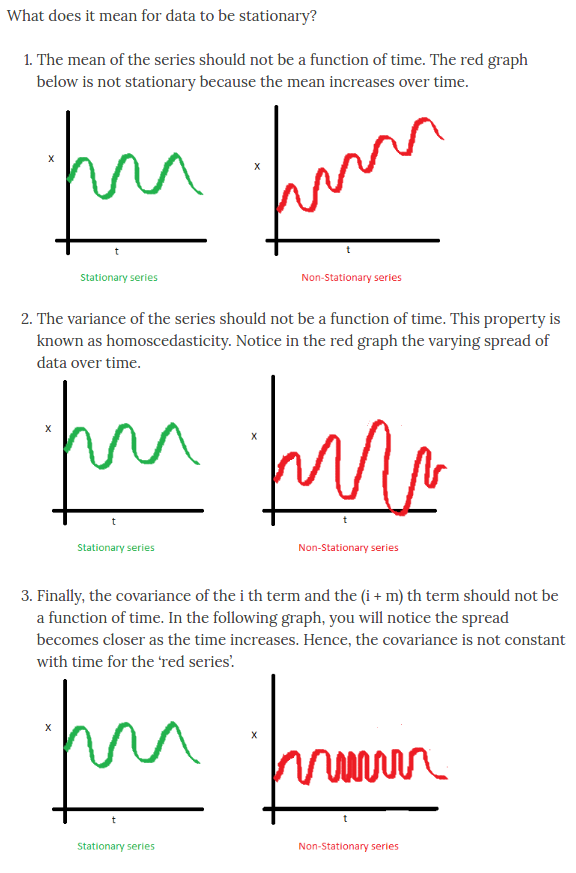

<IPython.core.display.Javascript object>

In [89]:
Image(filename=media, height=400, width=400)

### Are These Series Stationary?

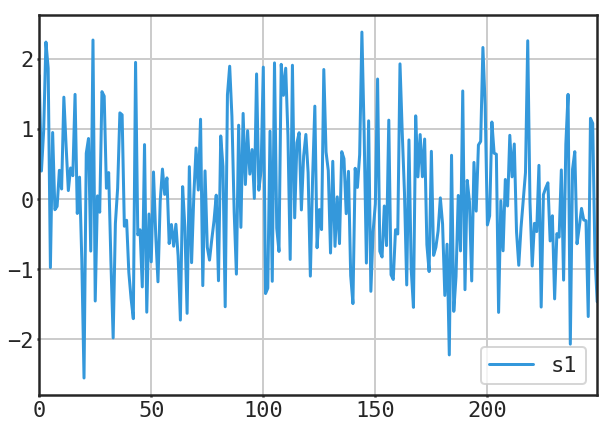

<IPython.core.display.Javascript object>

In [97]:
np.random.seed(0)
s1 = pd.Series(np.random.randn(250)).rename("s1")
ax = s1.plot(legend=True)
plt.savefig(visual_dir + "s1.png", **savefig_kwds)

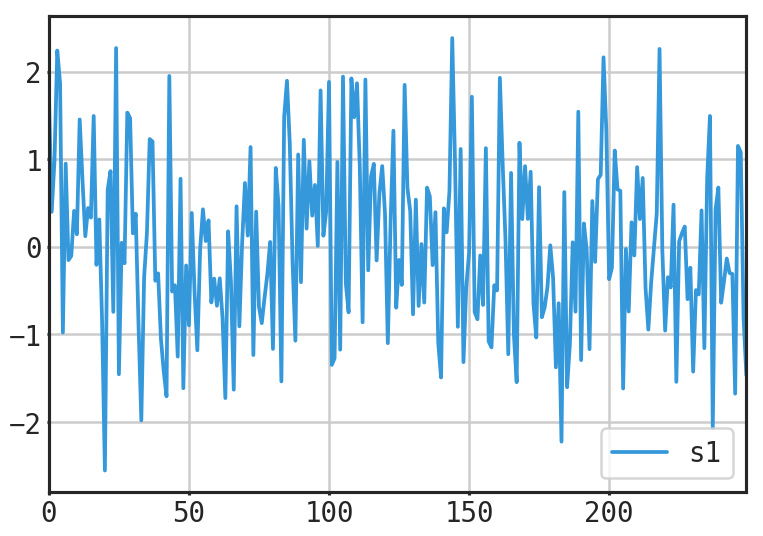

<IPython.core.display.Javascript object>

In [98]:
Image(visual_dir + "s1.png")

In [20]:
KPSS(s1).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
    KPSS Stationarity Test Results   
=====================================
Test Statistic                  0.182
P-value                         0.306
Lags                               16
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.
"""

<IPython.core.display.Javascript object>

In [21]:
def get_adf_df(y):
    res = sm.tsa.adfuller(y, regression="ct")
    idx = ["test_stat", "pval", "1%", "5%", "10%"]
    res = (res[0], res[1], res[4]["1%"], res[4]["5%"], res[4]["10%"])
    res = pd.DataFrame(res, columns=[y.name], index=idx).T
    return res


get_adf_df(s1)

test_stat   pval      1%      5%     10%
s1   -15.4291 0.0000 -3.9956 -3.4283 -3.1375

<IPython.core.display.Javascript object>

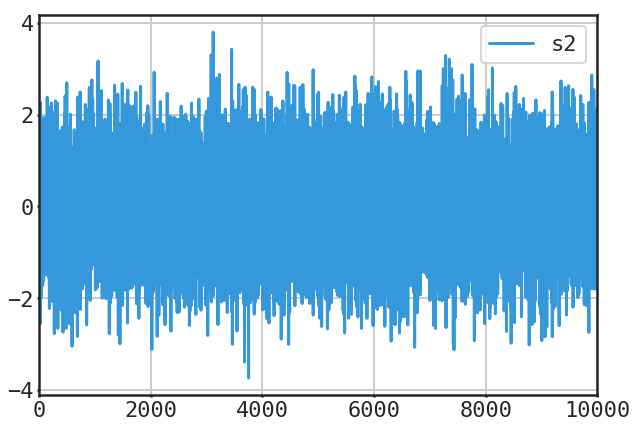

<IPython.core.display.Javascript object>

In [99]:
np.random.seed(0)
s2 = pd.Series(np.random.randn(10000)).rename("s2")
ax = s2.plot(legend=True)
plt.savefig(visual_dir + "s2.png", **savefig_kwds)

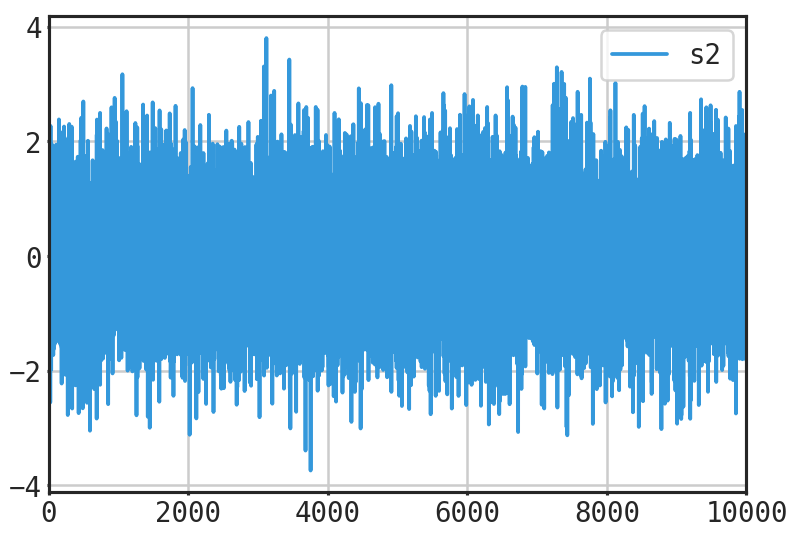

<IPython.core.display.Javascript object>

In [100]:
Image(visual_dir + "s2.png")

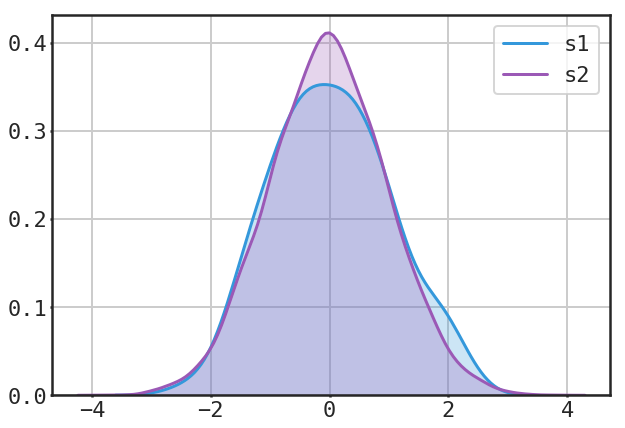

<IPython.core.display.Javascript object>

In [101]:
g = sns.kdeplot(s1, shade=True)
g = sns.kdeplot(s2, shade=True)

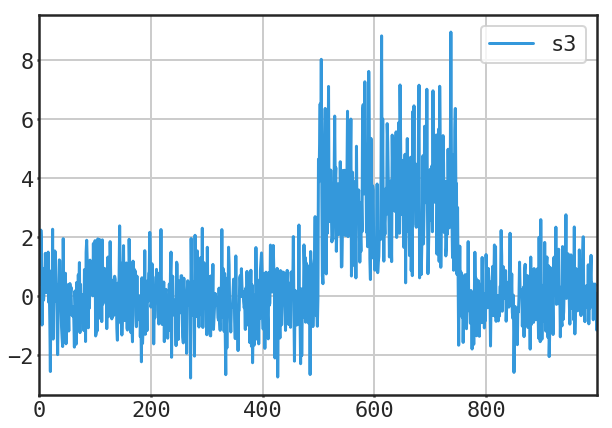

<IPython.core.display.Javascript object>

In [102]:
np.random.seed(0)
s3 = pd.Series(np.random.randn(1000)).rename("s3")
s3.iloc[500:750] = np.random.rayleigh(size=250, scale=2.5)
g = s3.plot(legend=True)
plt.savefig(visual_dir + "s3.png", **savefig_kwds)

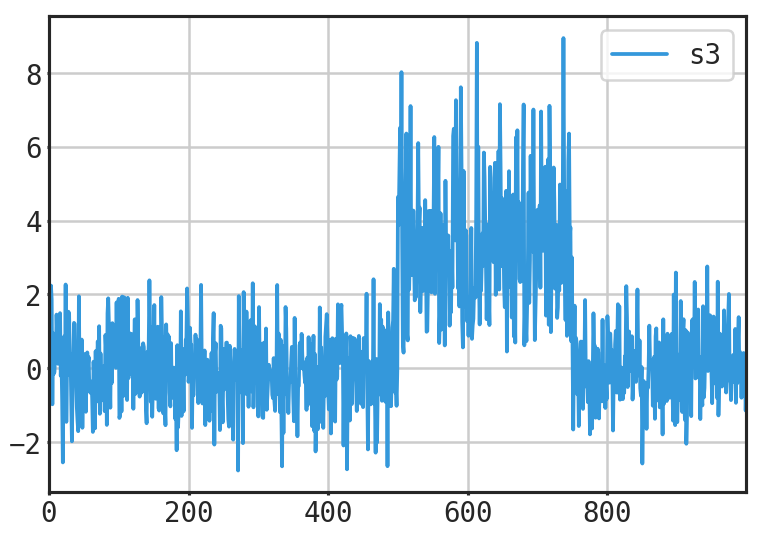

<IPython.core.display.Javascript object>

In [103]:
Image(visual_dir + "s3.png")

In [104]:
KPSS(s3).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
    KPSS Stationarity Test Results   
=====================================
Test Statistic                  0.917
P-value                         0.004
Lags                               22
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.
"""

<IPython.core.display.Javascript object>

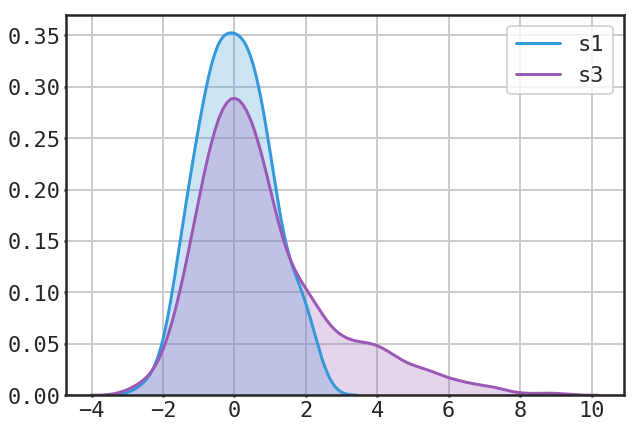

<IPython.core.display.Javascript object>

In [105]:
g = sns.kdeplot(s1, shade=True)
g = sns.kdeplot(s3, shade=True)

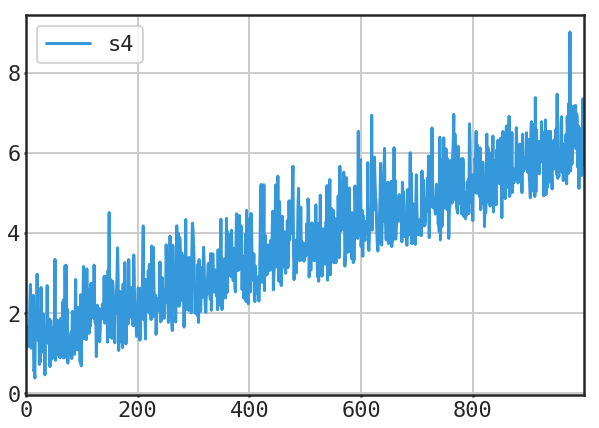

<IPython.core.display.Javascript object>

In [106]:
np.random.seed(0)
# s4 = pd.Series(np.random.randn(1000)).rename("s4") + np.linspace(0.1, 5, 1000)
s4 = pd.Series(np.random.rayleigh(size=1000)).rename("s4") + np.linspace(0.1, 5, 1000)
g = s4.plot(legend=True)
plt.savefig(visual_dir + "s4.png", **savefig_kwds)

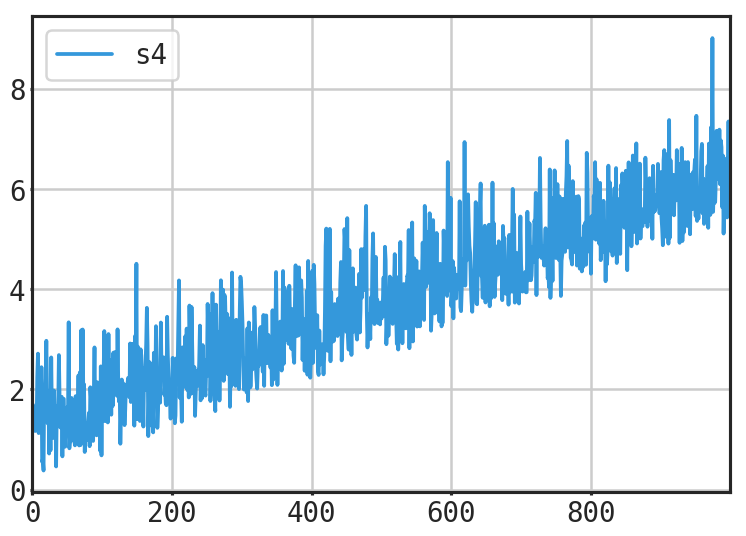

<IPython.core.display.Javascript object>

In [107]:
Image(visual_dir + "s4.png")

In [108]:
KPSS(s4).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
    KPSS Stationarity Test Results   
=====================================
Test Statistic                  4.396
P-value                         0.000
Lags                               22
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.
"""

<IPython.core.display.Javascript object>

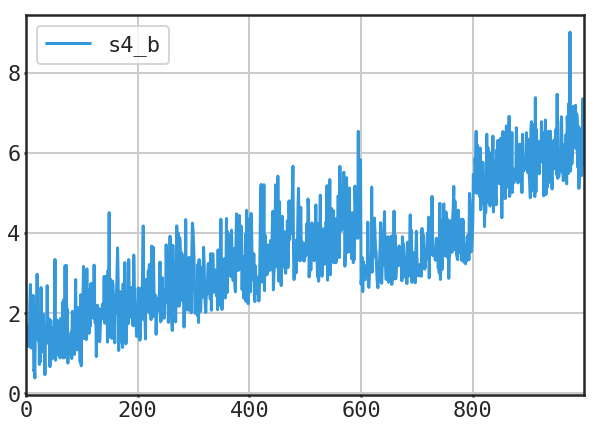

<IPython.core.display.Javascript object>

In [109]:
np.random.seed(0)
s4_b = pd.Series(np.random.rayleigh(size=1000)).rename("s4_b") + np.linspace(
    0.1, 5, 1000
)
s4_b.iloc[600:800] = s4_b / np.random.exponential(scale=1.5)
g = s4_b.plot(legend=True)
plt.savefig(visual_dir + "s4_b.png", **savefig_kwds)

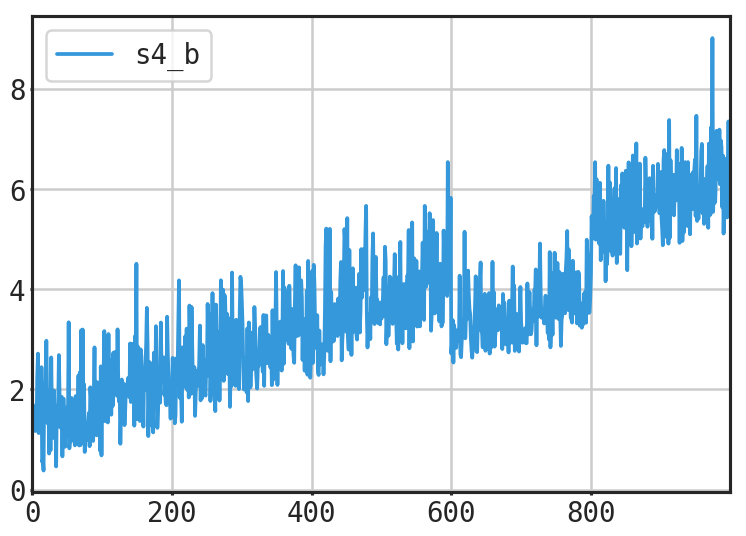

<IPython.core.display.Javascript object>

In [110]:
Image(visual_dir + "s4_b.png")

In [111]:
KPSS(s4_b).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
    KPSS Stationarity Test Results   
=====================================
Test Statistic                  3.749
P-value                         0.000
Lags                               22
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.
"""

<IPython.core.display.Javascript object>

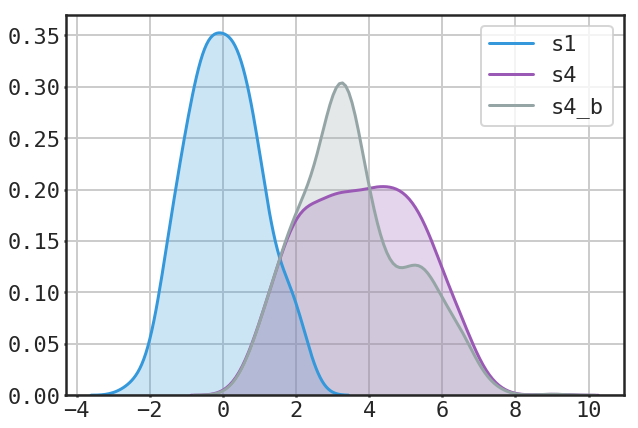

<IPython.core.display.Javascript object>

In [112]:
g = sns.kdeplot(s1, shade=True)
g = sns.kdeplot(s4, shade=True)
g = sns.kdeplot(s4_b, shade=True)

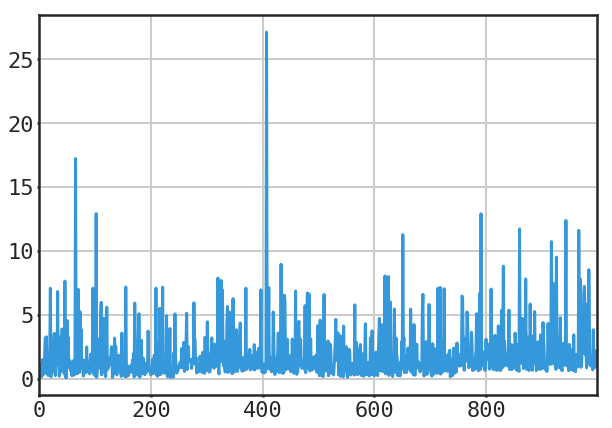

<IPython.core.display.Javascript object>

In [113]:
np.random.seed(7542)
s5 = pd.Series(np.random.lognormal(size=1000)).rename("s5")
s5.iloc[250:500] = s5.shift() + np.random.exponential() * 1.5
s5.iloc[750:1000] = s5.shift() + np.random.exponential() * 1.5
g = s5.plot()
plt.savefig(visual_dir + "s5.png", **savefig_kwds)

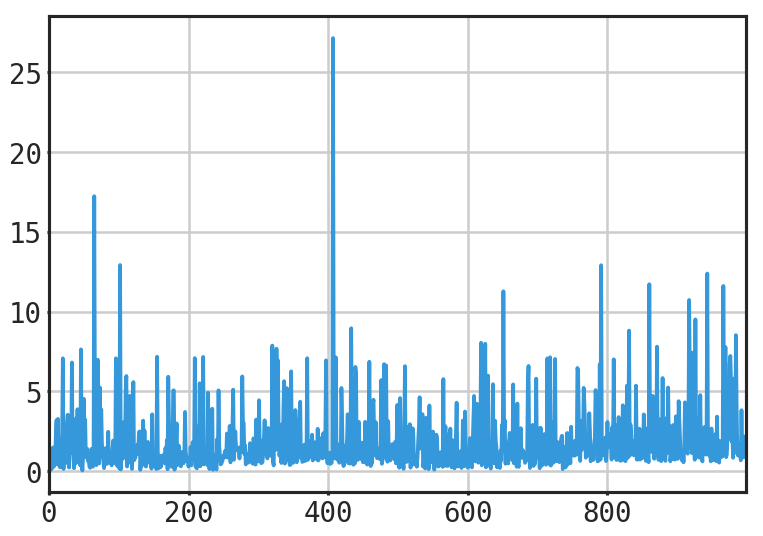

<IPython.core.display.Javascript object>

In [114]:
Image(visual_dir + "s5.png")

In [115]:
KPSS(s5).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
    KPSS Stationarity Test Results   
=====================================
Test Statistic                  0.731
P-value                         0.011
Lags                               22
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.
"""

<IPython.core.display.Javascript object>

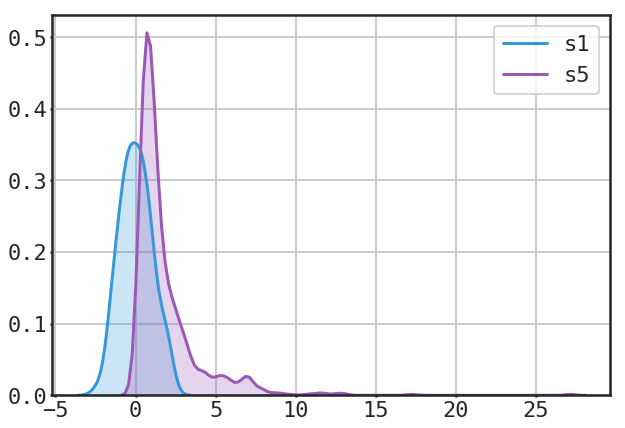

<IPython.core.display.Javascript object>

In [116]:
g = sns.kdeplot(s1, shade=True)
g = sns.kdeplot(s5, shade=True)

In [117]:
def sample_signal(n_samples, corr, mu=0, sigma=1):
    # assert 0 < corr < 1, "Auto-correlation must be between 0 and 1"

    # Find out the offset `c` and the std of the white noise `sigma_e`
    # that produce a signal with the desired mean and variance.
    # See https://en.wikipedia.org/wiki/Autoregressive_model
    # under section "Example: An AR(1) process".
    c = mu * (1 - corr)
    sigma_e = np.sqrt((sigma ** 2) * (1 - corr ** 2))

    # Sample the auto-regressive process.
    signal = [c + np.random.normal(0, sigma_e)]
    for _ in range(1, n_samples):
        signal.append(c + corr * signal[-1] + np.random.normal(0, sigma_e))

    return np.array(signal)

<IPython.core.display.Javascript object>

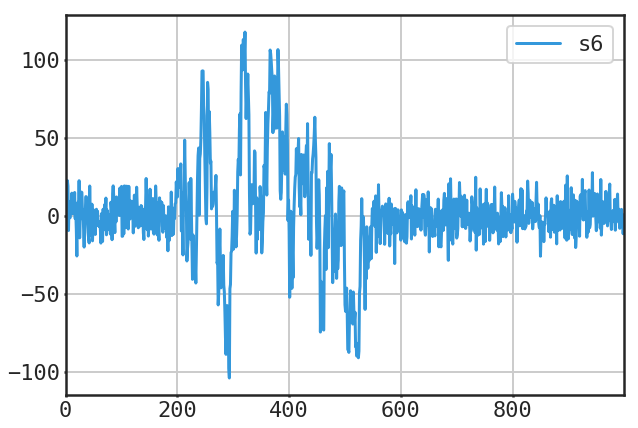

<IPython.core.display.Javascript object>

In [118]:
np.random.seed(0)
s6 = pd.Series(sample_signal(1000, 0.02, sigma=10)).rename("s6")
s6.iloc[200:550] = sample_signal(350, 0.9, sigma=50)  # + np.linspace(100, 110, 350)
g = s6.plot(legend=True)
plt.savefig(visual_dir + "s6.png", **savefig_kwds)

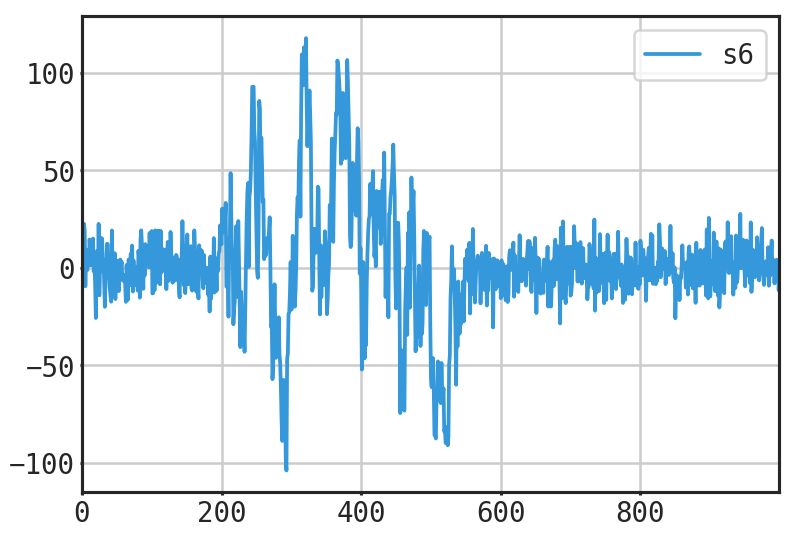

<IPython.core.display.Javascript object>

In [119]:
Image(visual_dir + "s6.png")

In [120]:
KPSS(s6).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
    KPSS Stationarity Test Results   
=====================================
Test Statistic                  0.206
P-value                         0.256
Lags                               22
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.
"""

<IPython.core.display.Javascript object>

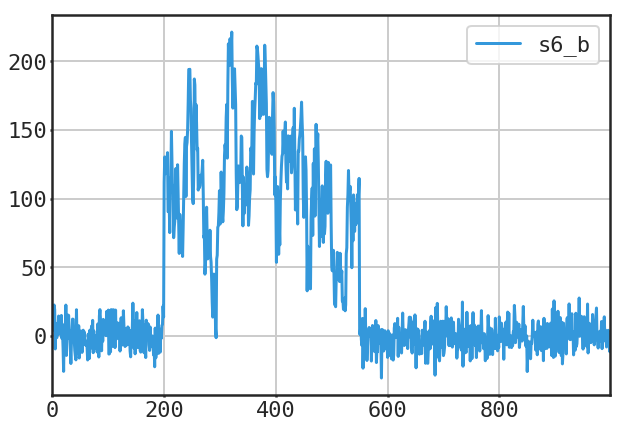

<IPython.core.display.Javascript object>

In [121]:
np.random.seed(0)
s6_b = pd.Series(sample_signal(1000, 0.02, sigma=10)).rename("s6_b")
s6_b.iloc[200:550] = sample_signal(350, 0.9, sigma=50) + np.linspace(100, 110, 350)
g = s6_b.plot(legend=True)
plt.savefig(visual_dir + "s6_b.png", **savefig_kwds)

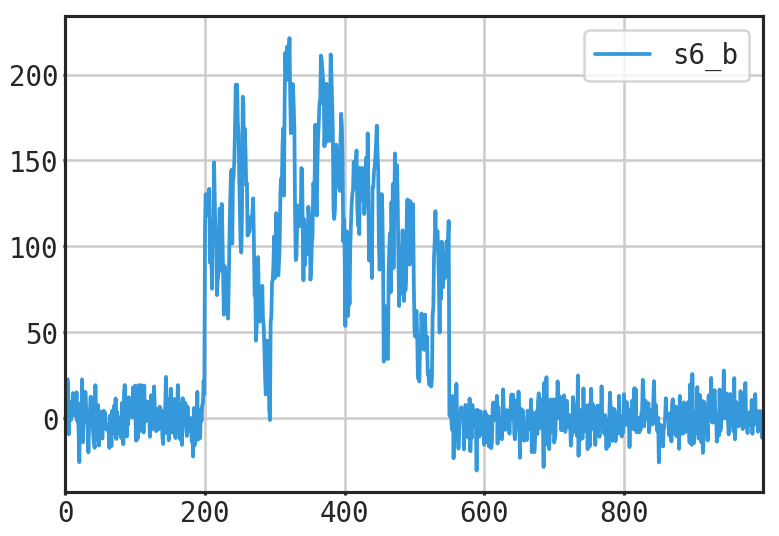

<IPython.core.display.Javascript object>

In [122]:
Image(visual_dir + "s6_b.png")

In [123]:
KPSS(s6_b)

<class 'arch.unitroot.unitroot.KPSS'>
"""
    KPSS Stationarity Test Results   
=====================================
Test Statistic                  1.190
P-value                         0.001
Lags                               22
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.
"""

<IPython.core.display.Javascript object>

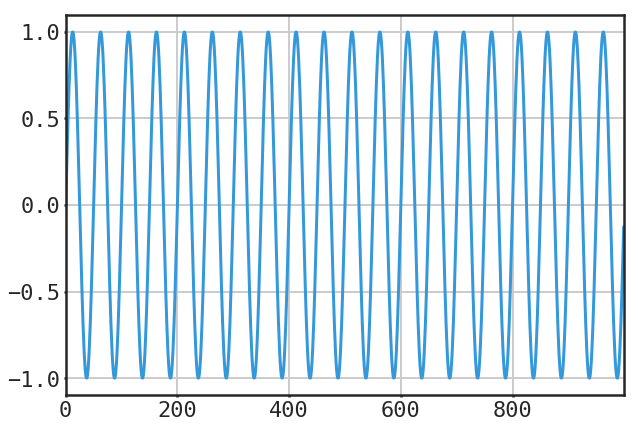

<IPython.core.display.Javascript object>

In [124]:
Fs = 500
f = 10
sample = 1000
x = np.arange(sample)
s7 = pd.Series(np.sin(2 * np.pi * f * x / Fs))
g = s7.plot()
plt.savefig(visual_dir + "s7.png", **savefig_kwds)

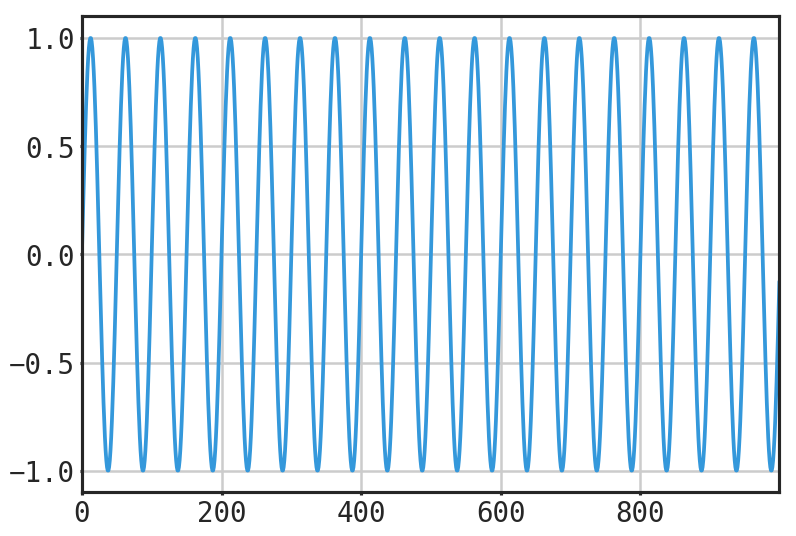

<IPython.core.display.Javascript object>

In [125]:
Image(visual_dir + "s7.png")

In [126]:
KPSS(s7).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
    KPSS Stationarity Test Results   
=====================================
Test Statistic                  0.017
P-value                         0.996
Lags                               22
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.
"""

<IPython.core.display.Javascript object>

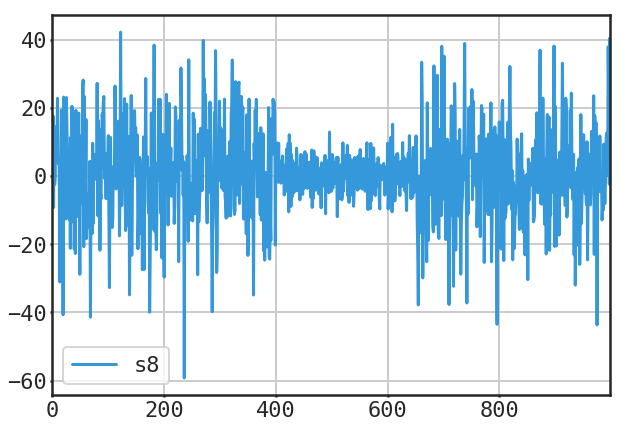

<IPython.core.display.Javascript object>

In [127]:
np.random.seed(3192)
s8 = pd.Series(sample_signal(1000, 0.03, sigma=15)).rename("s8")
s8.iloc[400:650] = sample_signal(250, -0.2, sigma=5)
g = s8.plot(legend=True)
plt.savefig(visual_dir + "s8.png", **savefig_kwds)

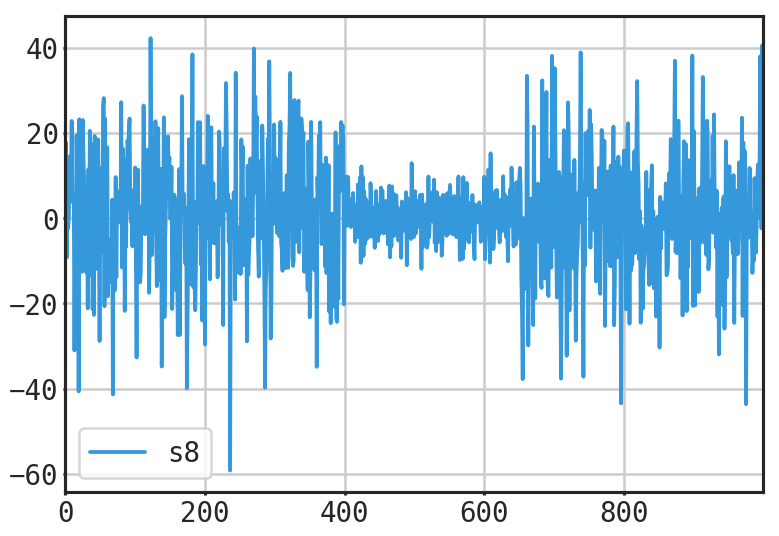

<IPython.core.display.Javascript object>

In [128]:
Image(visual_dir + "s8.png")

In [129]:
KPSS(s8).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
    KPSS Stationarity Test Results   
=====================================
Test Statistic                  0.097
P-value                         0.600
Lags                               22
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.
"""

<IPython.core.display.Javascript object>

## How Asset Returns Violate Rules of Stationarity

Now that you are familiarized with the concept of stationary time series, the remainder of this notebook will demonstrate/discuss some of the nuances and challenges one runs into in when trying to predict time series. 

Before we start just know that the behavior of securities' returns challenges these requirements of stationarity and our attempts to predict them in ways that are sometimes unknowable. This is a very humbling realization but is a necessary fact that requires a strategic response in the practice of return prediction.

### Do The Means and Standard Deviations vary with Time?

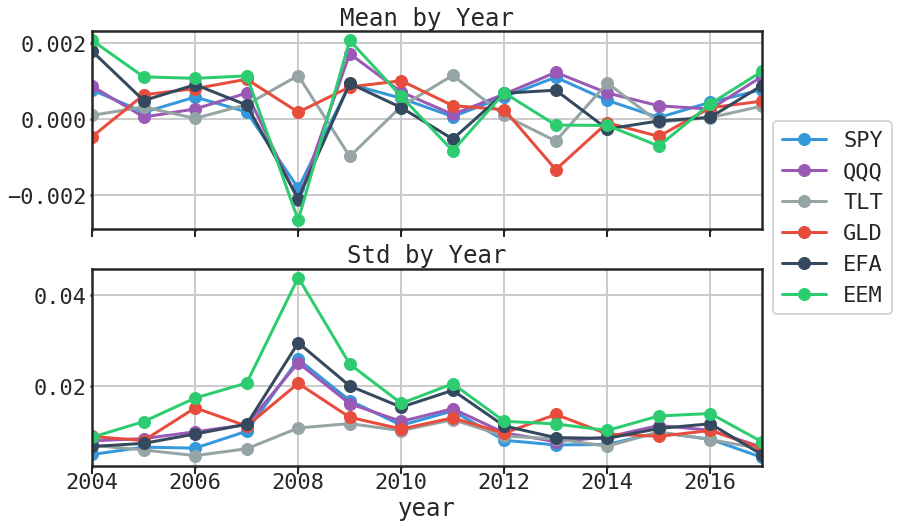

<IPython.core.display.Javascript object>

In [130]:
f, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
g = R.groupby("year").agg(["mean"]).plot(ax=axes[0], marker="o")
g = R.groupby("year").agg(["std"]).plot(ax=axes[1], marker="o")
_ = axes[0].legend(R.columns[:-1], bbox_to_anchor=(1.0, 0.6))
_ = axes[1].legend().set_visible(False)
_ = axes[0].set_title("Mean by Year")
_ = axes[1].set_title("Std by Year")
plt.savefig(visual_dir + "mean_std_devs_by_year.png", **savefig_kwds)

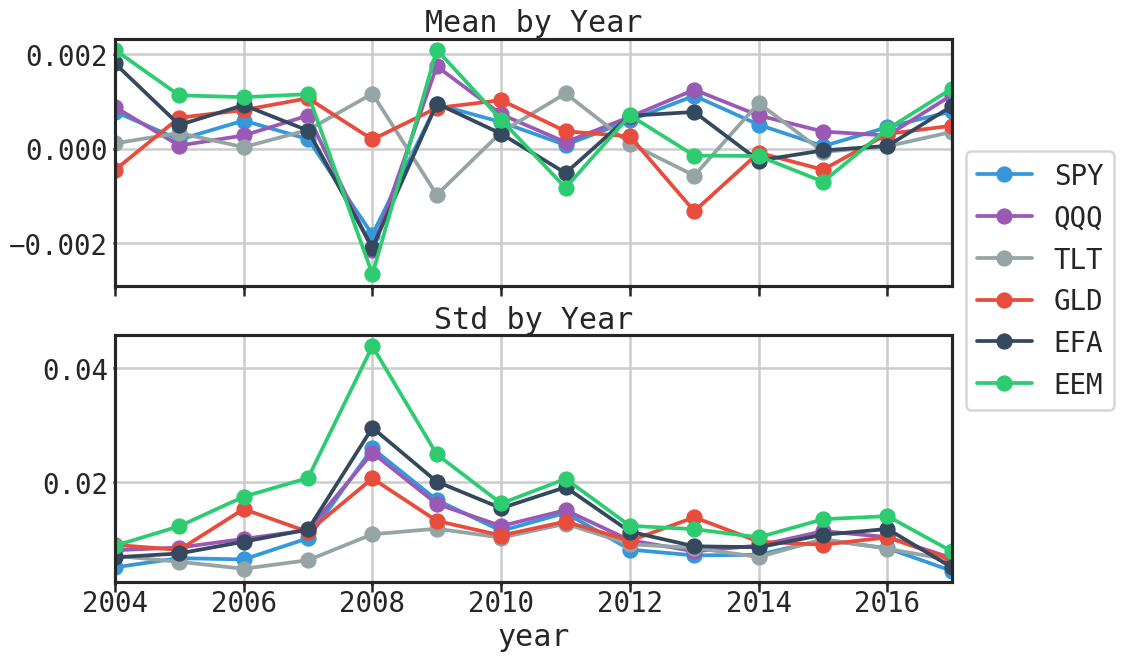

<IPython.core.display.Javascript object>

In [131]:
Image(visual_dir + "mean_std_devs_by_year.png")

### The annual means and standard deviations vary signficantly across years.

One way we can examine whether the returns are stationary is looking at the mean and standard deviation of returns by year. If those two quantities are not supposed to be a function of time then they should be pretty similar across years, right?

Just by eyeballing the previous plots you can see how varied the means and volatilities are. Sometimes the mean return is highly negative while volatility is spiked like in 2008-09 or it can be positive while volatlility is much lower as in 2017. 

### Examining Autocorrelation

Finally we can look for evidence of correlated data points by plotting the return series and its autocorrelation and partial autocorrelation function. We'll briefly look at plots by symbol and see if there are any correlated lags.

In [132]:
def plot_acf_by_symbol(returns, sym, ax=None):
    if not ax:
        fig, ax = plt.subplots()

    y = returns[sym]
    smt.graphics.plot_acf(y, ax=ax, lags=252, fft=True, zero=False, alpha=0.5)
    ax.set_title(f"{sym} Autocorrelation", fontweight="demi")


def plot_pacf_by_symbol(returns, sym, ax=None):
    if not ax:
        fig, ax = plt.subplots()

    y = returns[sym]
    smt.graphics.plot_pacf(y, ax=ax, lags=252, zero=False, alpha=0.5)
    ax.set_title(f"{sym} Partial Autocorrelation", fontweight="demi")

<IPython.core.display.Javascript object>

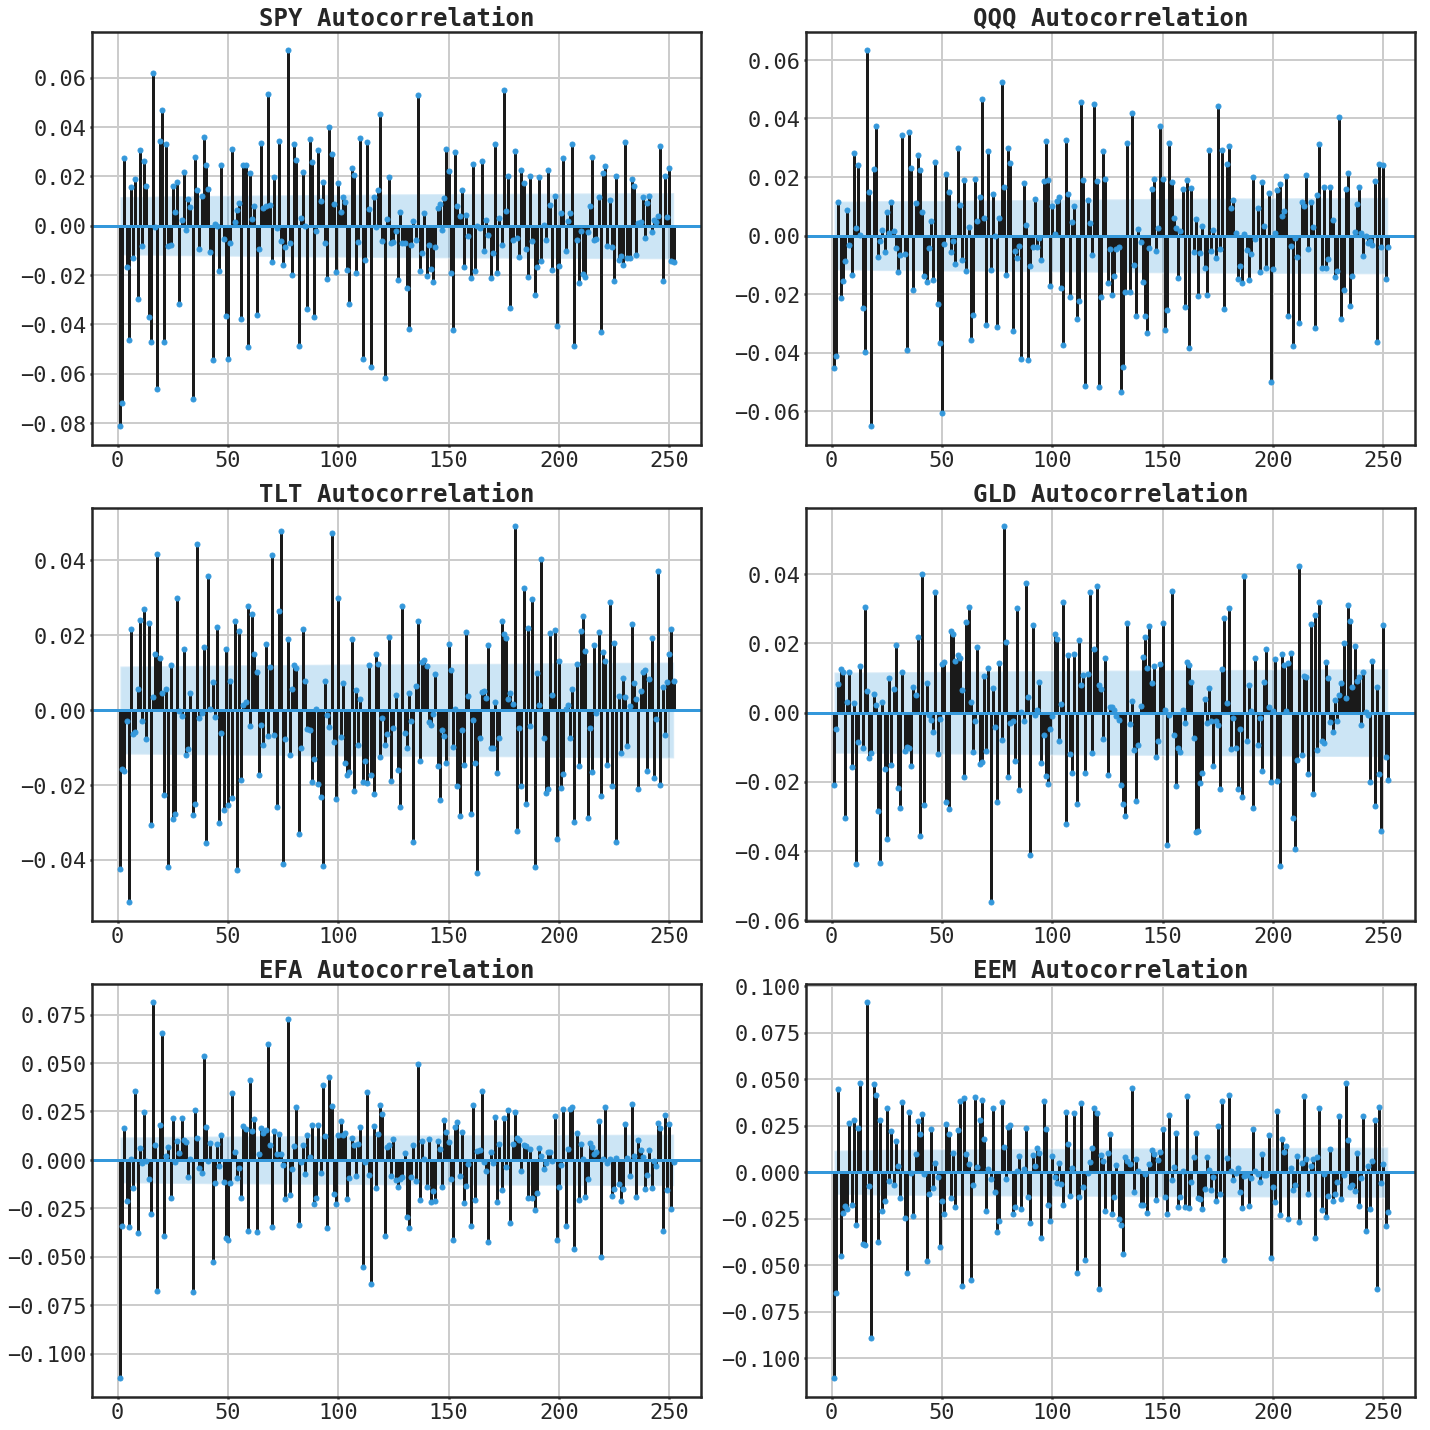

<IPython.core.display.Javascript object>

In [133]:
fig, axes = plt.subplots(3, 2, figsize=(20, 20))
for sym, ax in zip(R.columns[:-1], axes.flat):
    plot_acf_by_symbol(R, sym, ax=ax)
plt.tight_layout()
plt.savefig(visual_dir + "acf_by_symbol.png", **savefig_kwds)

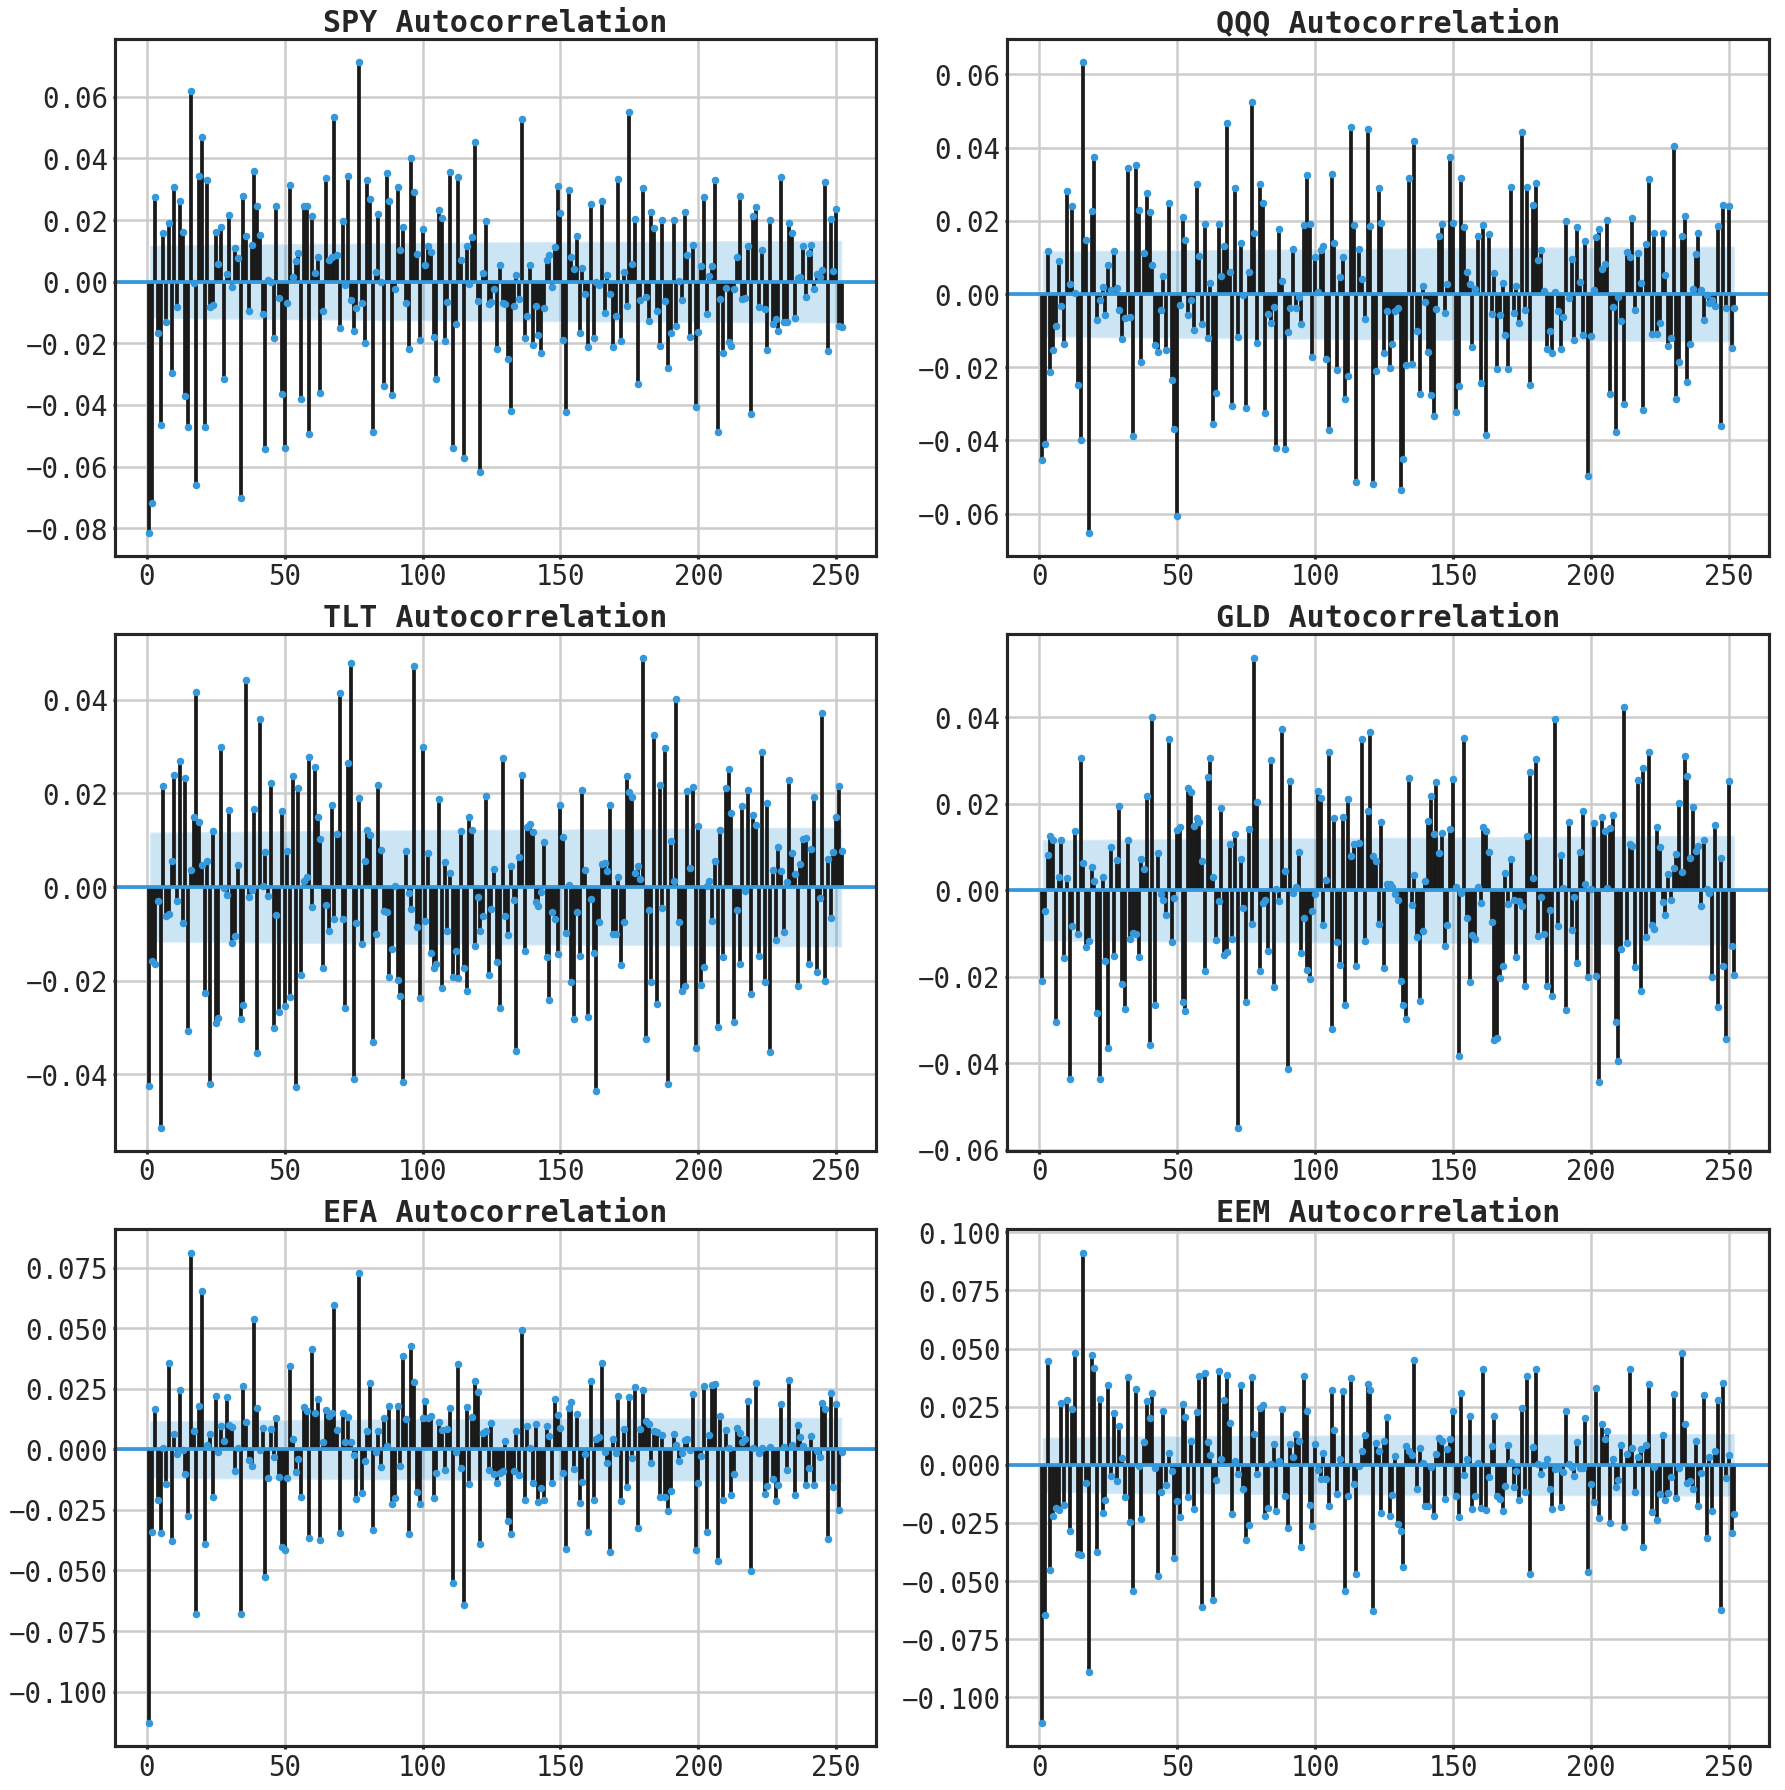

<IPython.core.display.Javascript object>

In [134]:
Image(visual_dir + "acf_by_symbol.png", height=600, width=600)

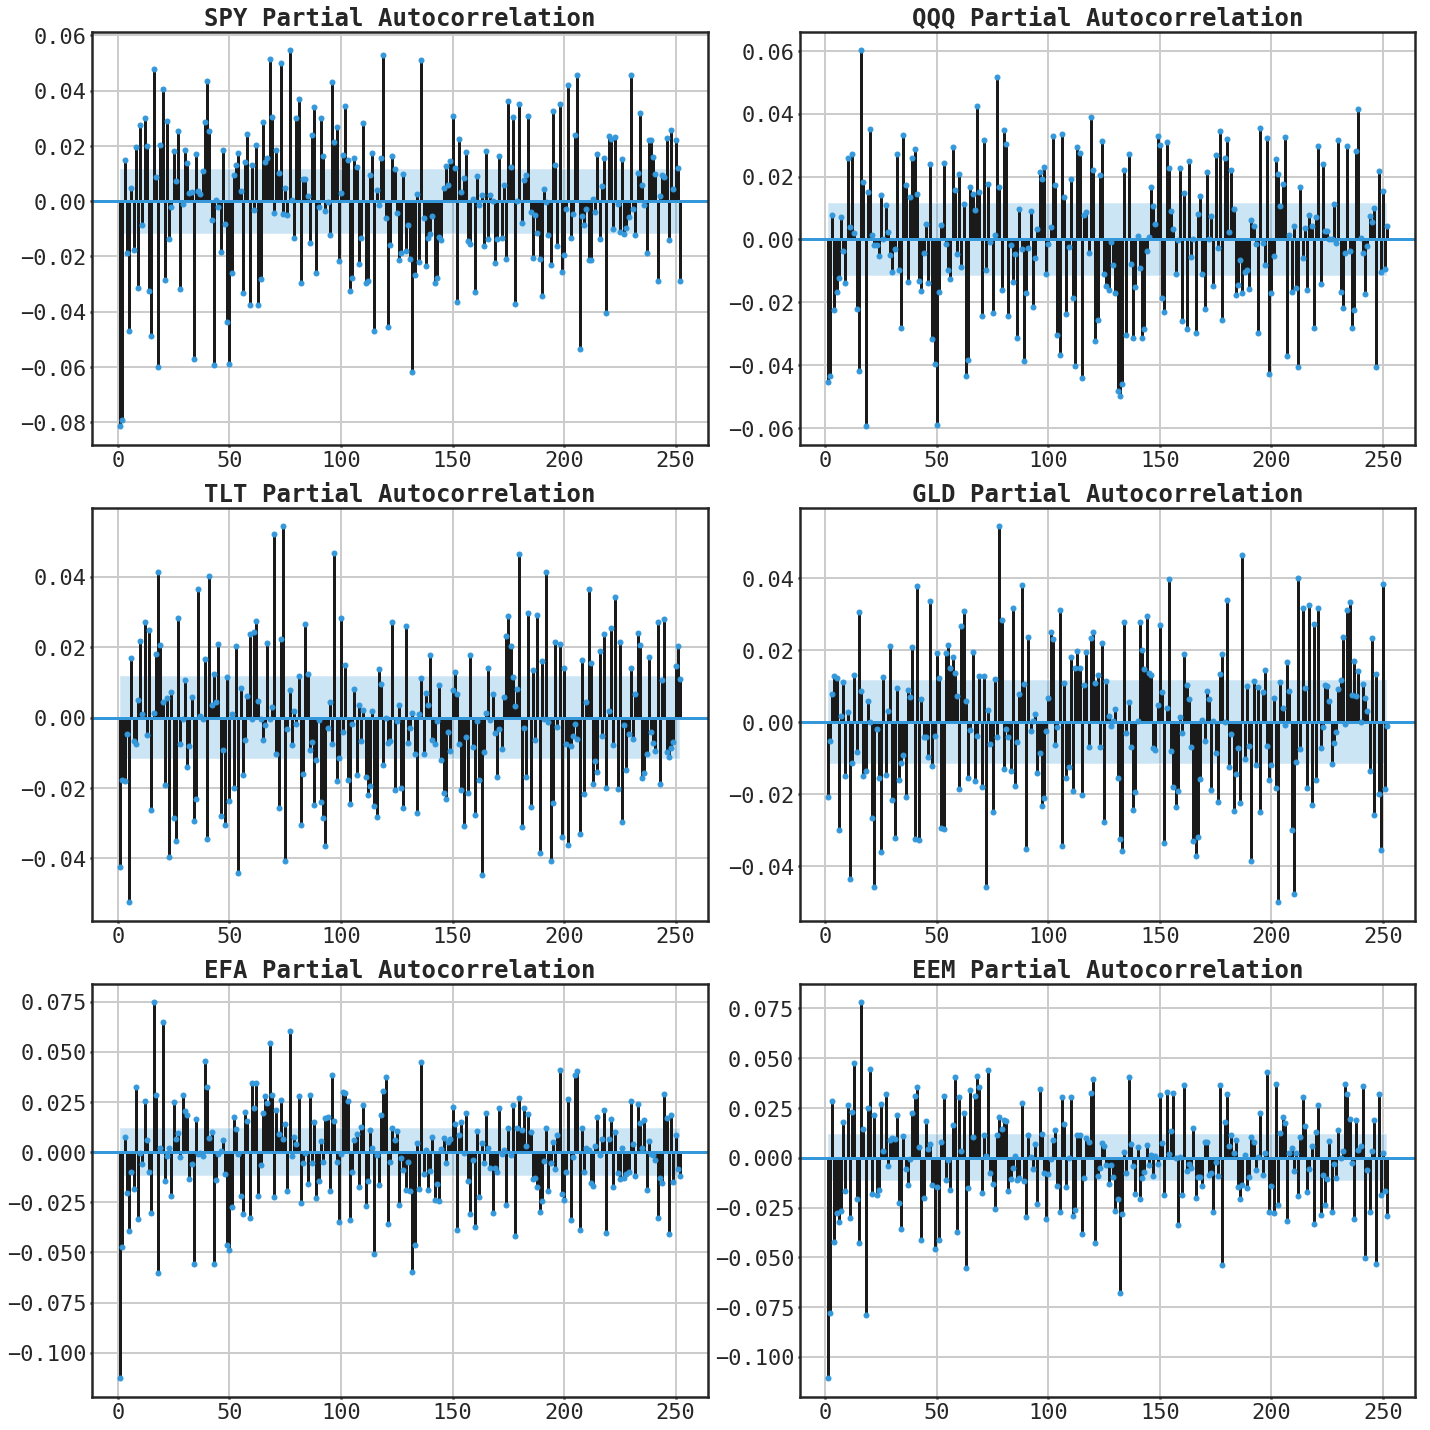

<IPython.core.display.Javascript object>

In [135]:
fig, axes = plt.subplots(3, 2, figsize=(20, 20))
for sym, ax in zip(R.columns[:-1], axes.flat):
    plot_pacf_by_symbol(R, sym, ax=ax)
plt.tight_layout()
plt.savefig(visual_dir + "pacf_by_symbol.png", **savefig_kwds)

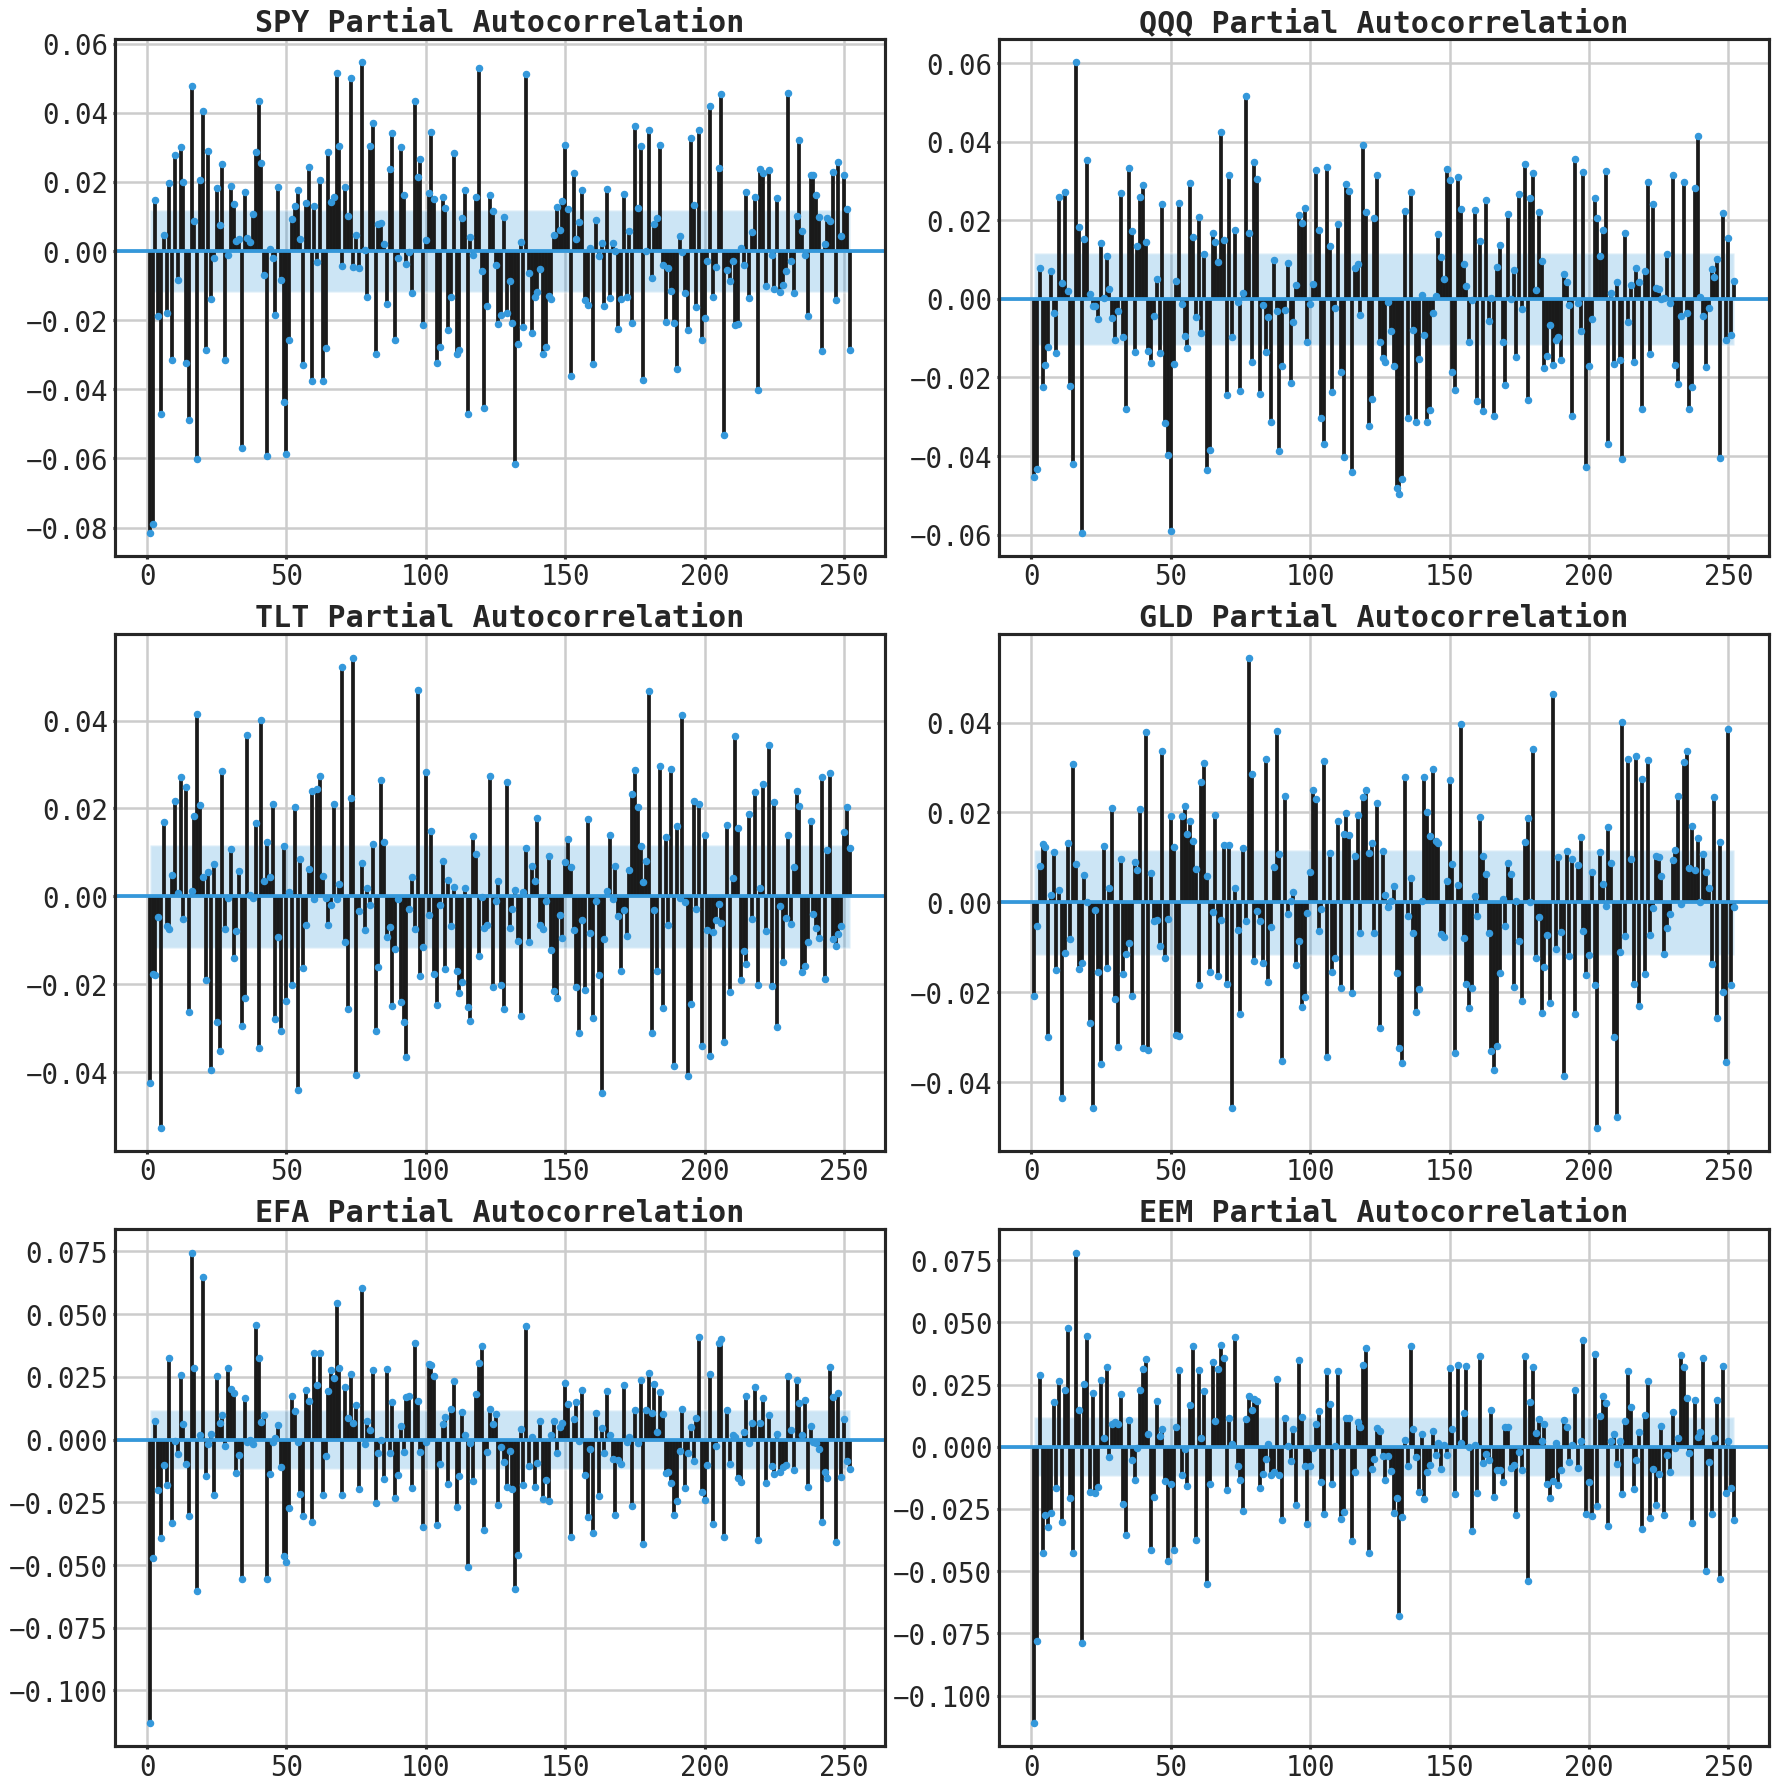

<IPython.core.display.Javascript object>

In [137]:
Image(visual_dir + "pacf_by_symbol.png", height=600, width=600)

Text(0.5, 1.0, 'ETF QQ Plots (all years)')

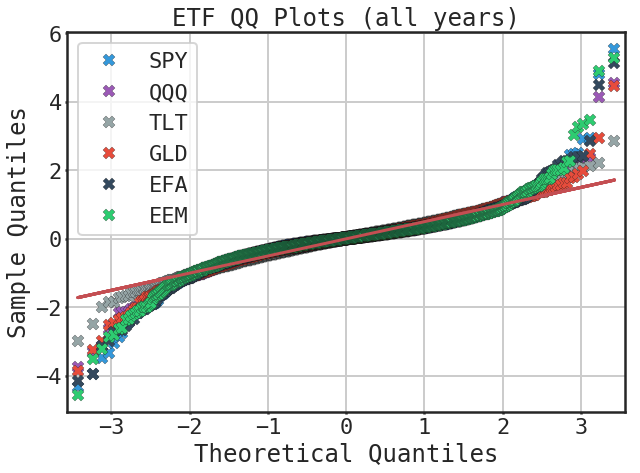

<IPython.core.display.Javascript object>

In [138]:
import itertools

fig, ax = plt.subplots()

for sym, color in zip(R.columns[:-1], itertools.cycle(flatui)):
    y = R[sym]
    # must scale y to fit
    y = (y - y.mean()) / (2 * y.std())
    sm.qqplot(
        y,
        line="s",
        ax=ax,
        marker="X",
        markerfacecolor=color,
        markeredgecolor="k",
        markeredgewidth=0.25,
        label=sym,
    )
plt.legend()
plt.title("ETF QQ Plots (all years)")

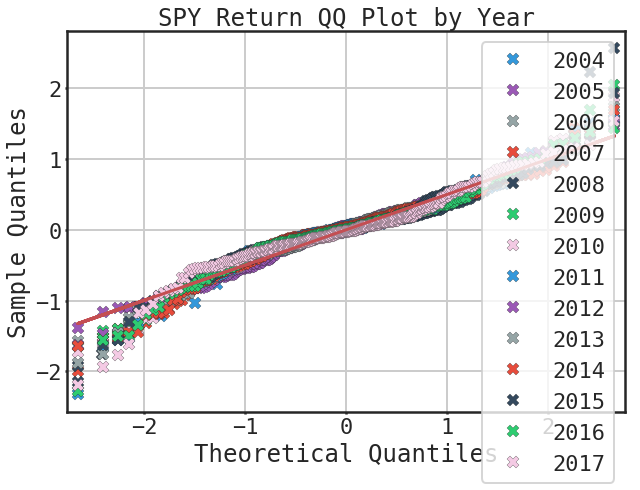

<IPython.core.display.Javascript object>

In [139]:
def plot_qq_by_year(returns, sym, ax=None):
    if not ax:
        fig, ax = plt.subplots()

    for year, color in zip(returns.year.unique(), itertools.cycle(flatui)):
        y = returns.query("year==@year")[sym]
        # must scale y to fit
        y = (y - y.mean()) / (2 * y.std())
        sm.qqplot(
            y,
            line="s",
            ax=ax,
            marker="X",
            markerfacecolor=color,
            markeredgecolor="k",
            markeredgewidth=0.25,
            label=year,
        )
    ax.legend()
    ax.set_title(f"{sym} Return QQ Plot by Year")


plot_qq_by_year(R, "SPY")

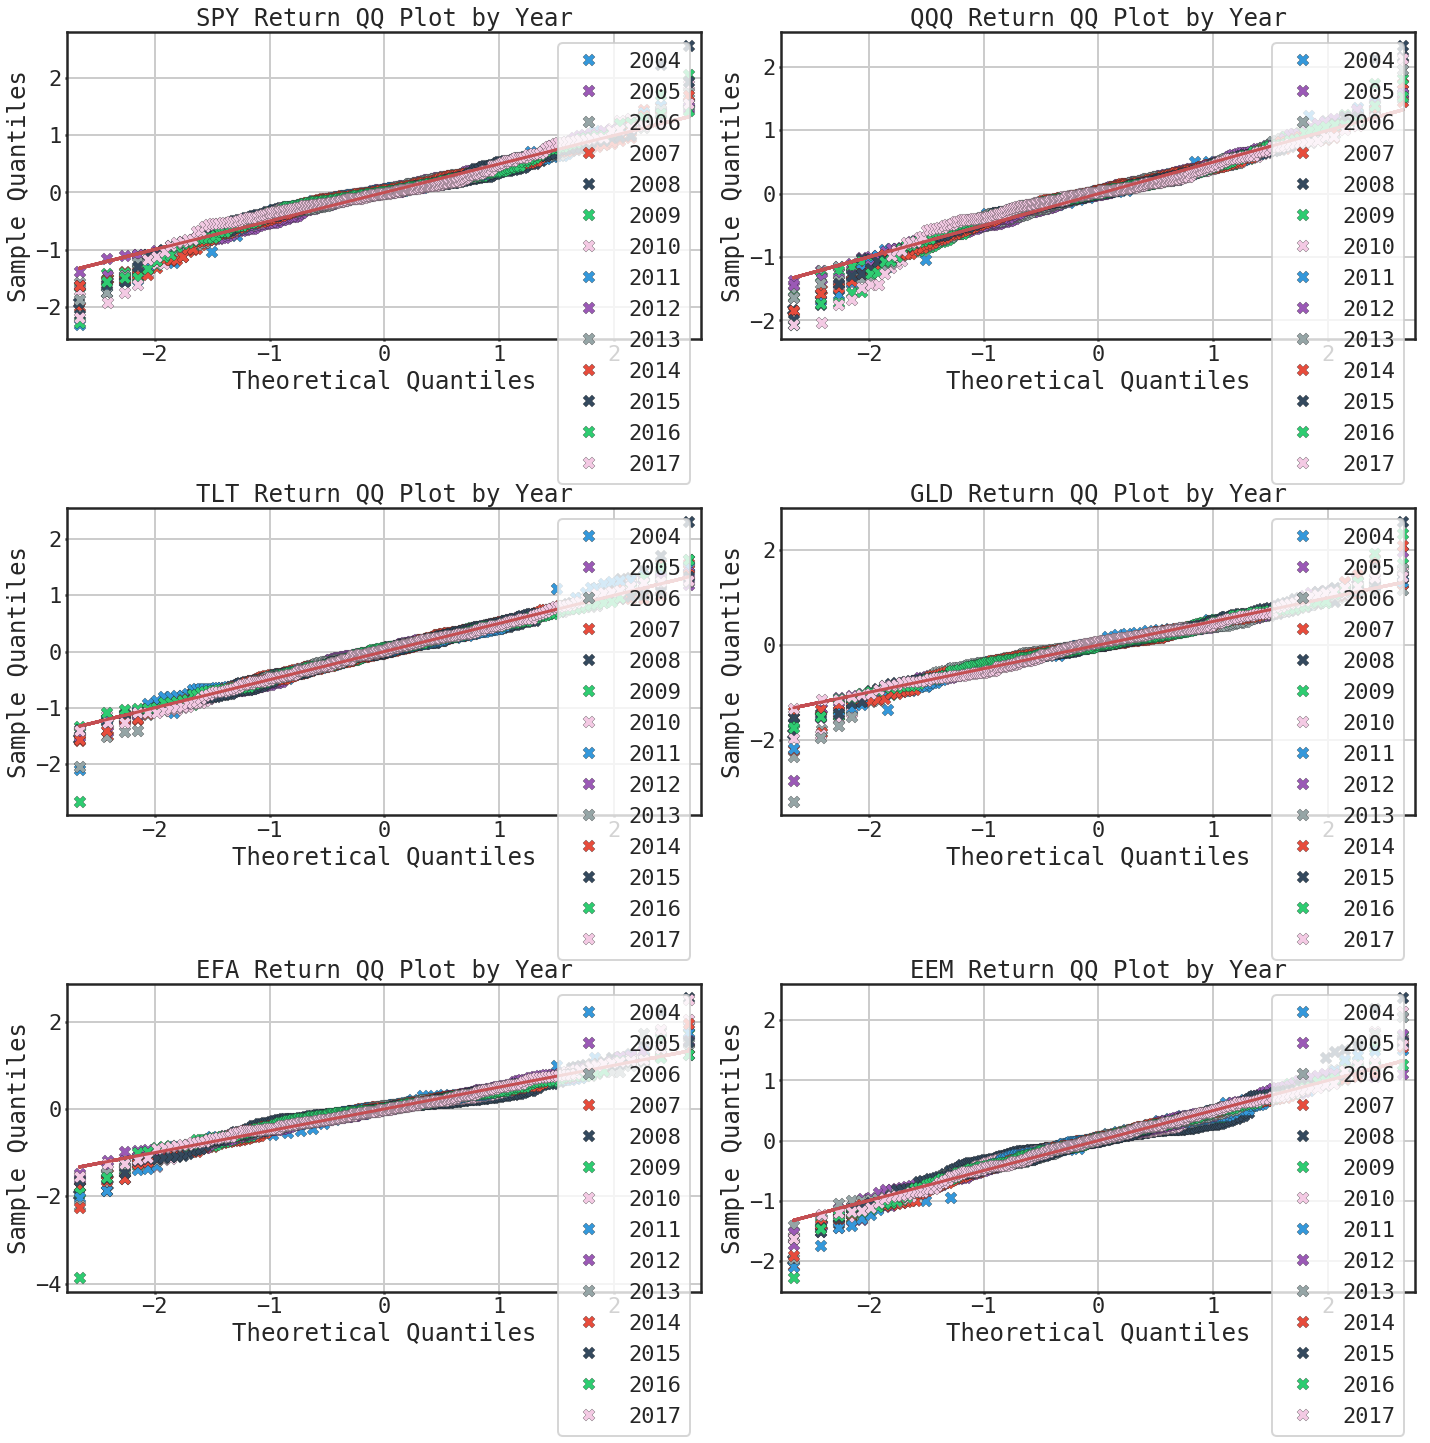

<IPython.core.display.Javascript object>

In [140]:
fig, axes = plt.subplots(3, 2, figsize=(20, 20))
for sym, ax in zip(R.columns[:-1], axes.flat):
    plot_qq_by_year(R, sym, ax=ax)
plt.tight_layout()

### What does this mean?

Imagine we have a basic mean reversion strategy and we use the previous year's mean and std deviation to set the parameters for our present strategy. 

In [141]:
def plot_strat_entry(train, test, dist=2, ax=None):
    if not ax:
        fig, ax = plt.subplots()

    ax.plot(
        test,
        color=flatui[0],
        marker="^",
        markersize=10,
        markerfacecolor="green",
        markeredgecolor="k",
        markevery=list(
            np.where(test < (train.mean() - dist * train.std()), True, False)
        ),
    )
    ax.plot(
        test,
        color=flatui[0],
        marker="v",
        markersize=10,
        markerfacecolor="red",
        markeredgecolor="k",
        markevery=list(
            np.where(test > (train.mean() + dist * train.std()), True, False)
        ),
    )
    ax.axhline(train.mean(), color="r", ls="--")
    ax.axhline(train.mean() + dist * train.std(), color="r", ls="--")
    ax.axhline(train.mean() - dist * train.std(), color="r", ls="--")
    train_year = train.index.year[0]
    test_year = test.index.year[0]
    ax.set_title(
        f"{test.name} train year: {train_year} | test year: {test_year}",
        fontweight="demi",
    )

<IPython.core.display.Javascript object>

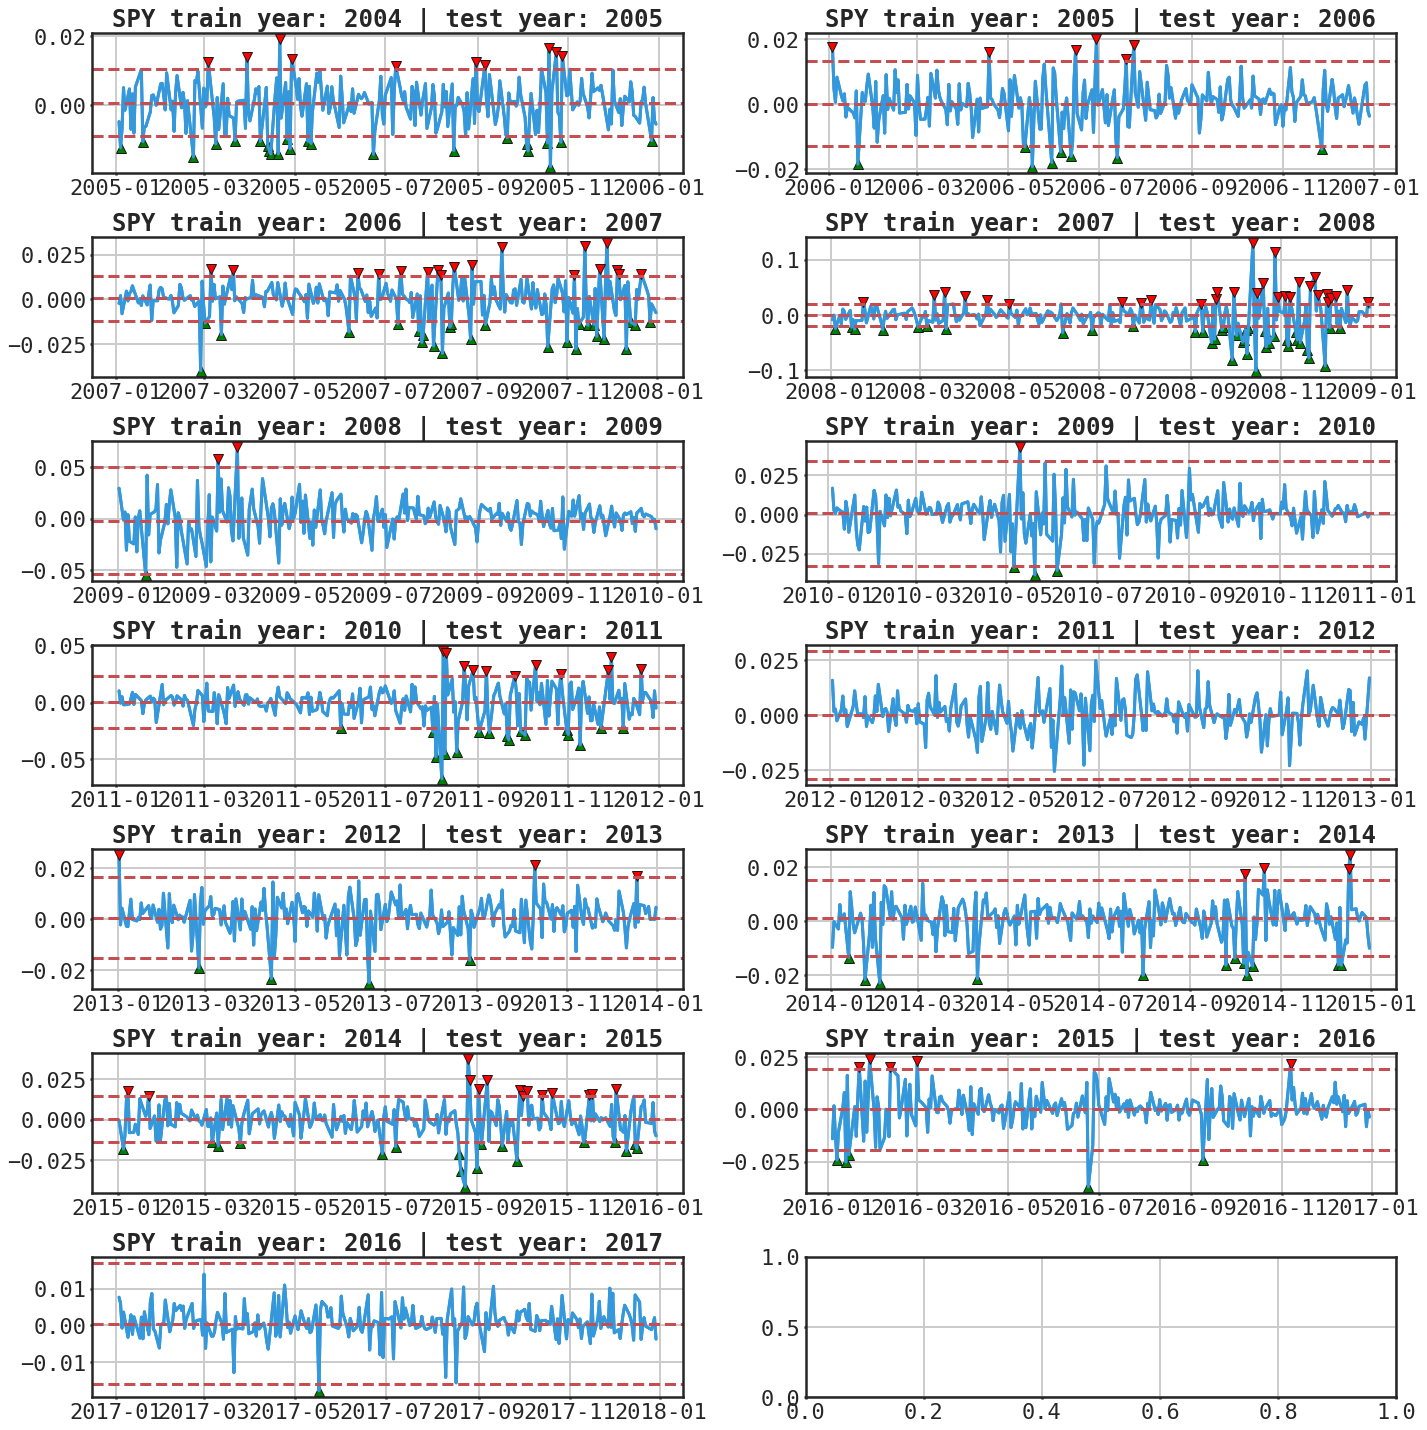

<IPython.core.display.Javascript object>

In [142]:
years = sorted(R.year.unique())
fig, axes = plt.subplots(7, 2, figsize=(20, 20))
for year, ax in zip(years[1:], axes.flat):
    trn = R["SPY"].loc[str(year - 1)]
    tst = R["SPY"].loc[str(year)]
    plot_strat_entry(trn, tst, ax=ax)
plt.tight_layout()
plt.savefig(visual_dir + "SPY_mr_entry_example.png", **savefig_kwds)

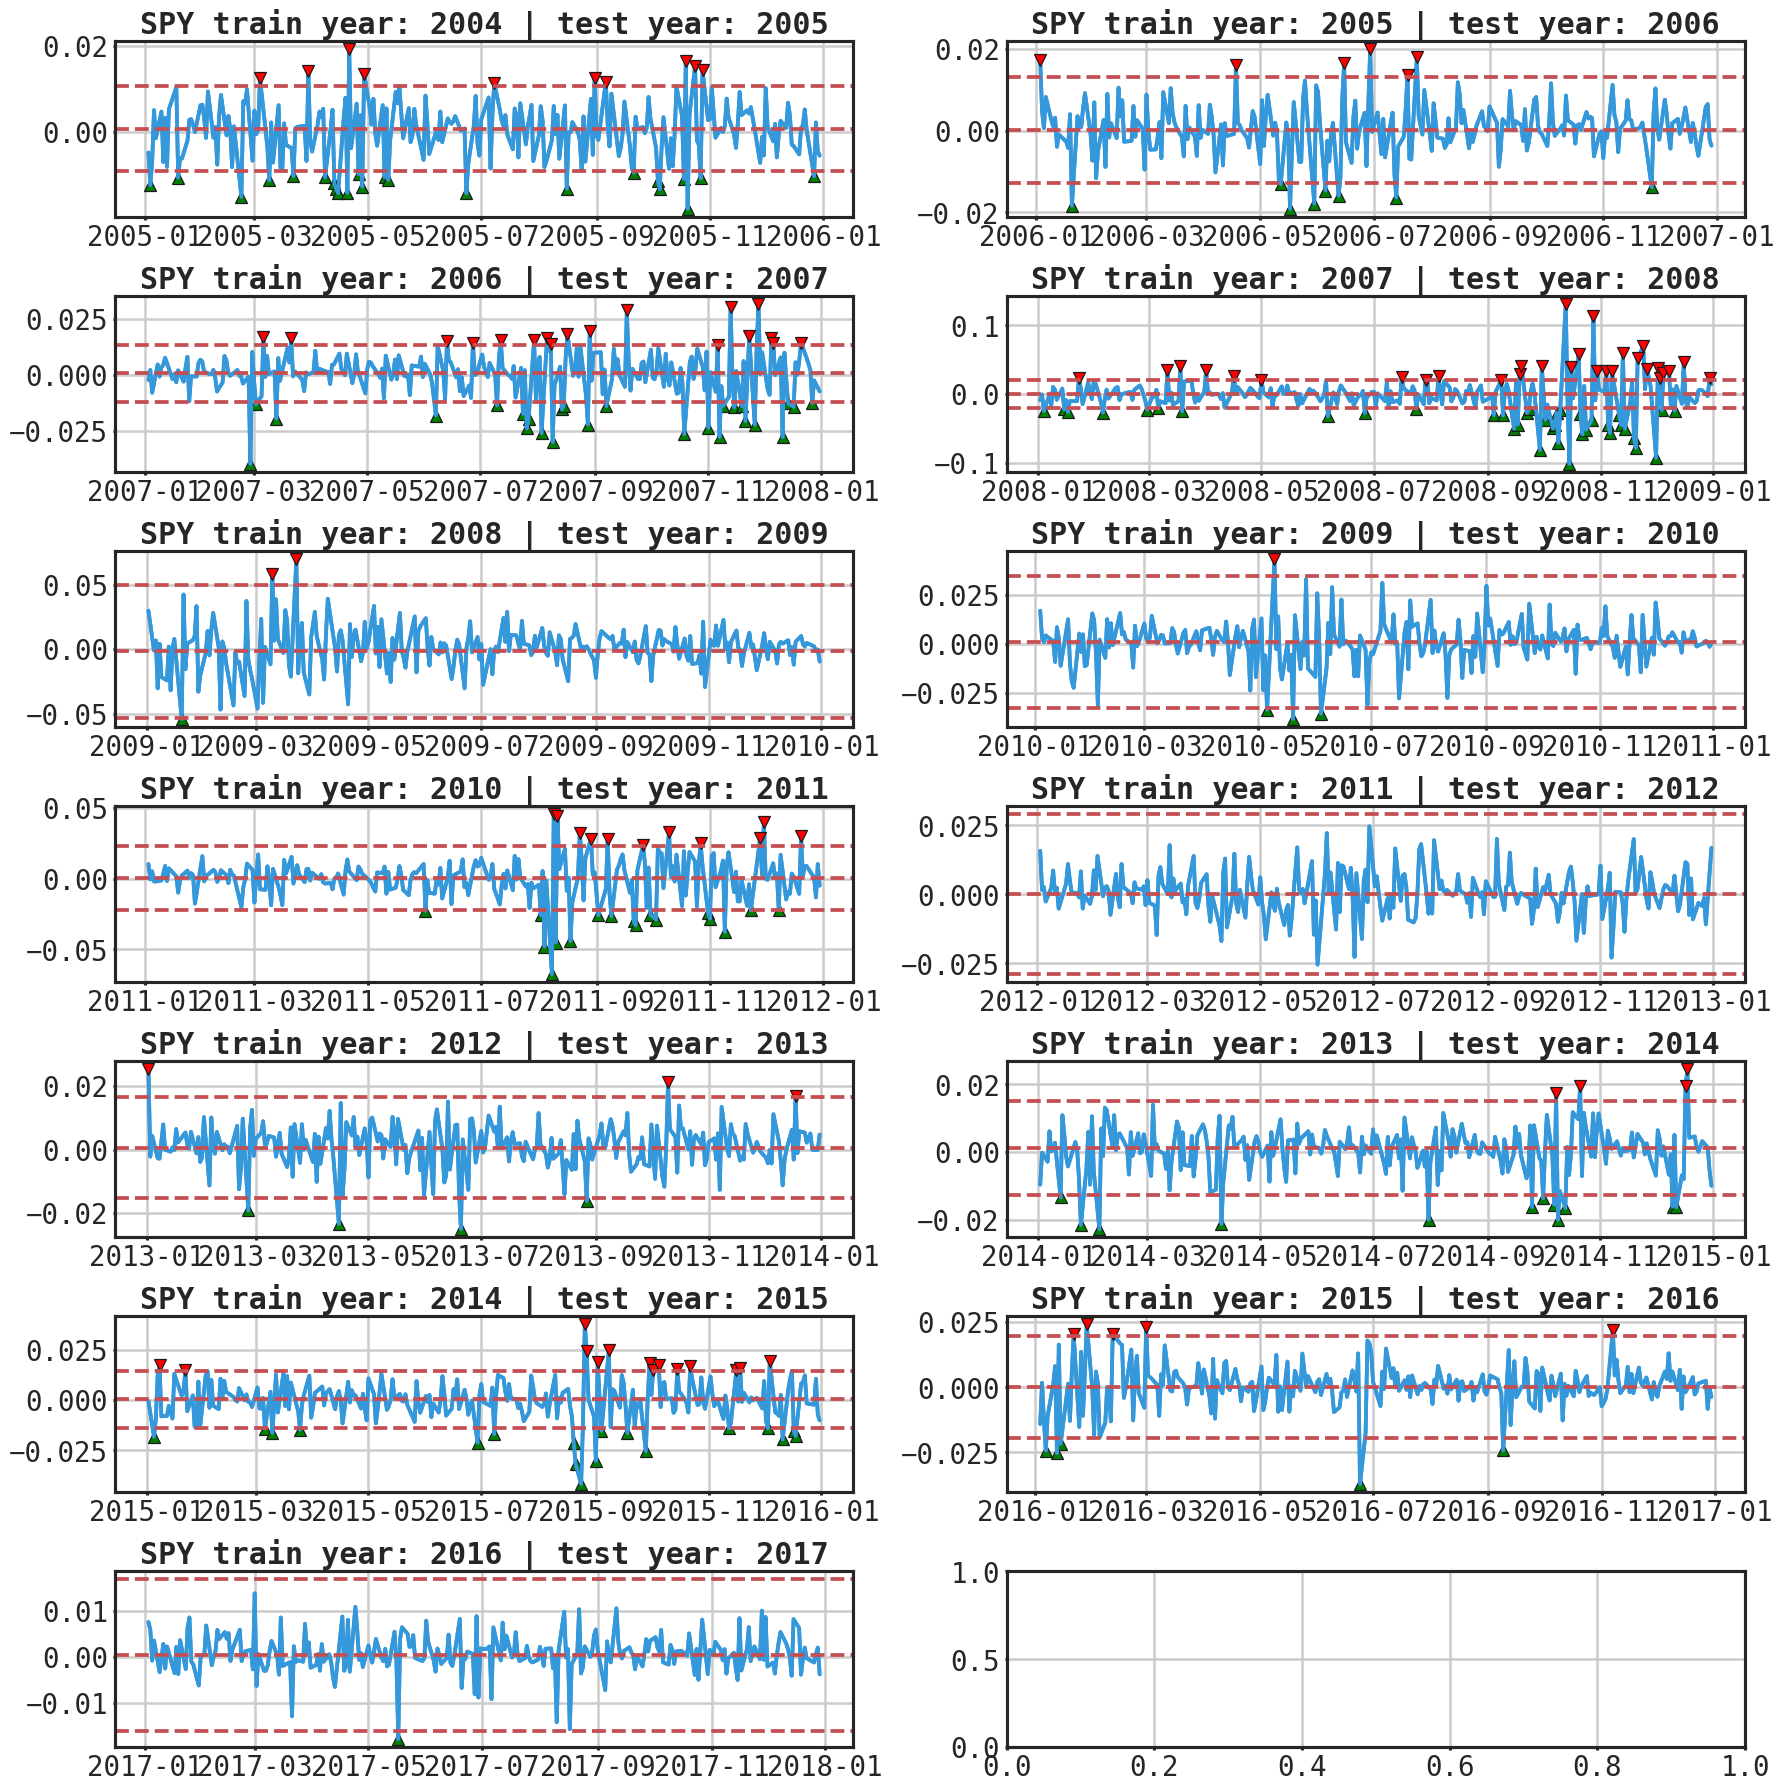

<IPython.core.display.Javascript object>

In [148]:
Image(visual_dir + "SPY_mr_entry_example.png", height=800, width=800)

In the previous image we can see examples where there are lots of trades for some years and very few trades other years due to the previous years low or high volatility.

To get a better idea of some of the potential risks involved we can calculate an estimate of the maximum adverse selection for each entry point. This assumes you were able to enter at the moment price crossed the outer bands and calculates the maximum distance between price and the band over that period.

In [144]:
def max_adverse_excursion(trn, tst, dist=2):
    upper_band = trn.mean() + dist * trn.std()
    lower_band = trn.mean() - dist * trn.std()

    tst_sell = tst[tst > upper_band]
    mae_sell = abs(tst_sell) - abs(upper_band)

    tst_buy = tst[tst < lower_band]
    mae_buy = abs(tst_buy) - abs(lower_band)

    return mae_sell, mae_buy


# ------------
dist = 2
maes = list()

for sym in R.columns[:-1]:
    for year in years[1:]:
        trn = R[sym].loc[str(year - 1)] * 100
        tst = R[sym].loc[str(year)] * 100
        ms, mb = max_adverse_excursion(trn, tst, dist=dist)
        ms = ms.to_frame().assign(entry="sell")
        mb = mb.to_frame().assign(entry="buy")
        mae = (
            pd.concat([ms, mb], axis=0)
            .reset_index()
            .rename(columns={sym: "value_pct"})
            .assign(
                symbol=sym,
                upper_band=trn.mean() + dist * trn.std(),
                lower_band=trn.mean() - dist * trn.std(),
                mean=trn.mean(),
            )
        )
        maes.append(mae)

mae_df = (
    pd.concat(maes)
    .assign(year=lambda df: df.date.dt.year)
    .sort_values(["symbol", "date"])
    .reset_index(drop=True)
)
cprint(mae_df)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
           date  value_pct entry symbol  upper_band  lower_band    mean  year
1397 2016-02-08     0.1676  sell    TLT      1.9615     -1.9758 -0.0072  2016
1398 2016-06-24     0.6878  sell    TLT      1.9615     -1.9758 -0.0072  2016
1399 2016-06-27     0.5045  sell    TLT      1.9615     -1.9758 -0.0072  2016
1400 2016-11-09     2.3601   buy    TLT      1.9615     -1.9758 -0.0072  2016
1401 2017-03-01     0.0601   buy    TLT      1.6358     -1.6265  0.0047  2017
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1402 entries, 0 to 1401
Data columns (total 8 columns):
date          1402 non-null datetime64[ns]
value_pct     1402 non-null float64
entry         1402 non-null object
symbol        1402 non-null object
upper_band    1402 non-null float64
lower_ba

<IPython.core.display.Javascript object>

In the following plot we will see how some years and symbols the per trade drawdown is very high.

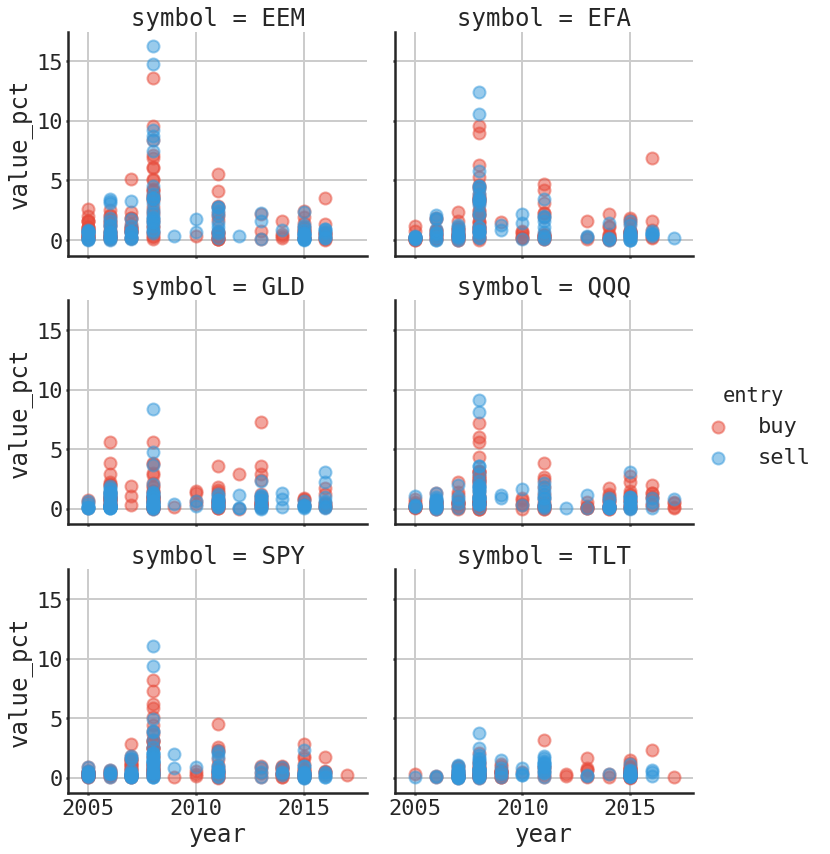

<IPython.core.display.Javascript object>

In [152]:
g = sns.FacetGrid(
    mae_df,
    col="symbol",
    hue="entry",
    col_wrap=2,
    height=4,
    aspect=1.25,
    hue_kws={"color": [flatui[3], flatui[0]]},
)
g.map(plt.scatter, "year", "value_pct", alpha=0.5)
g.add_legend()
plt.savefig(visual_dir + "mae.png", **savefig_kwds)

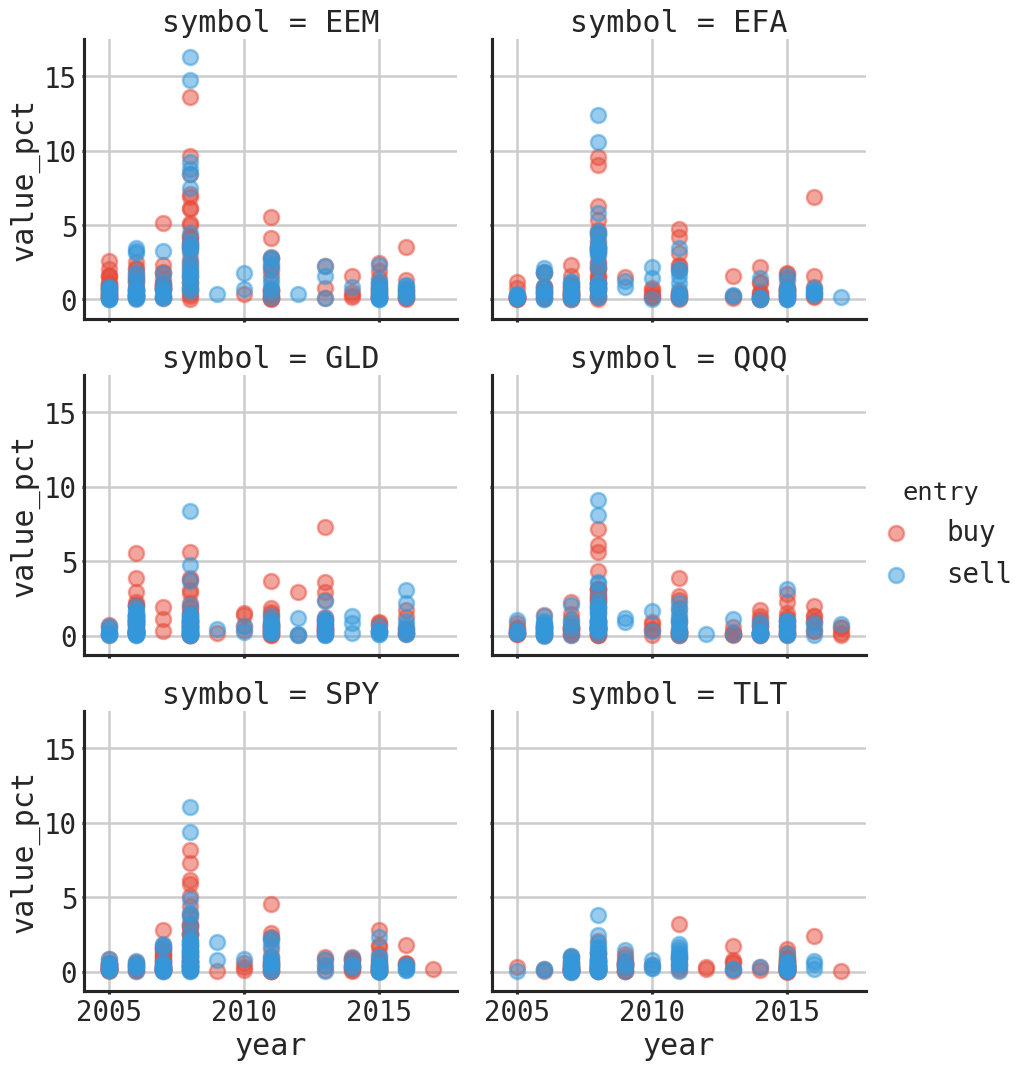

<IPython.core.display.Javascript object>

In [153]:
Image(visual_dir + "mae.png", height=600, width=600)

Below highlights the variation in trade counts per year by symbol.

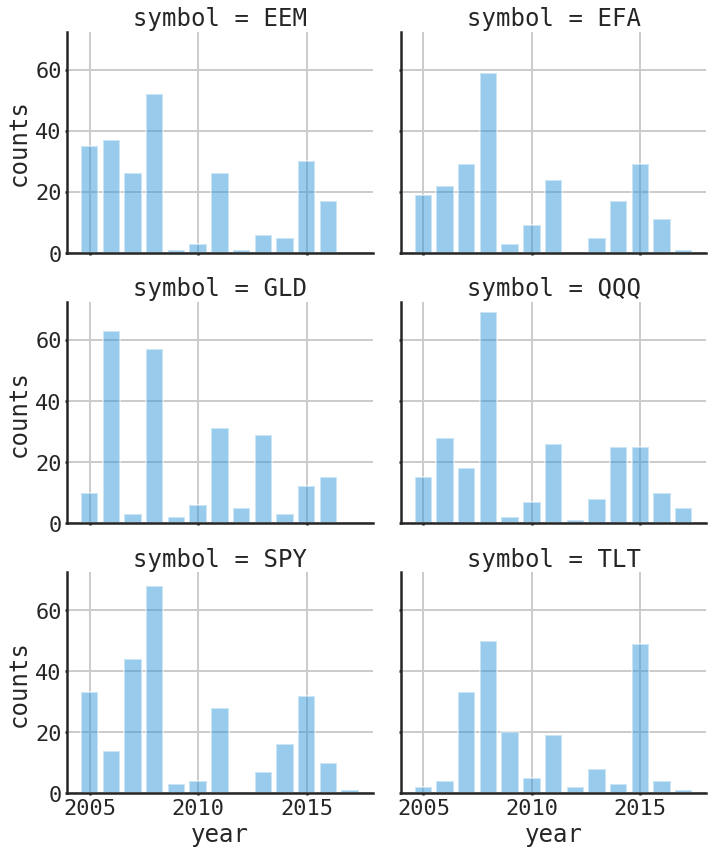

<IPython.core.display.Javascript object>

In [156]:
trade_counts = (
    mae_df.groupby(["symbol", "year"])["date"]
    .count()
    .reset_index()
    .rename(columns={"date": "counts"})
)

g = sns.FacetGrid(
    trade_counts,
    col="symbol",
    # hue="entry",
    col_wrap=2,
    height=4,
    aspect=1.25,
    # hue_kws={"color": [flatui[3], flatui[0]]},
)
g.map(plt.bar, "year", "counts", alpha=0.5)
g.add_legend()
plt.savefig(visual_dir + "trade_counts_facet_grid.png", **savefig_kwds)

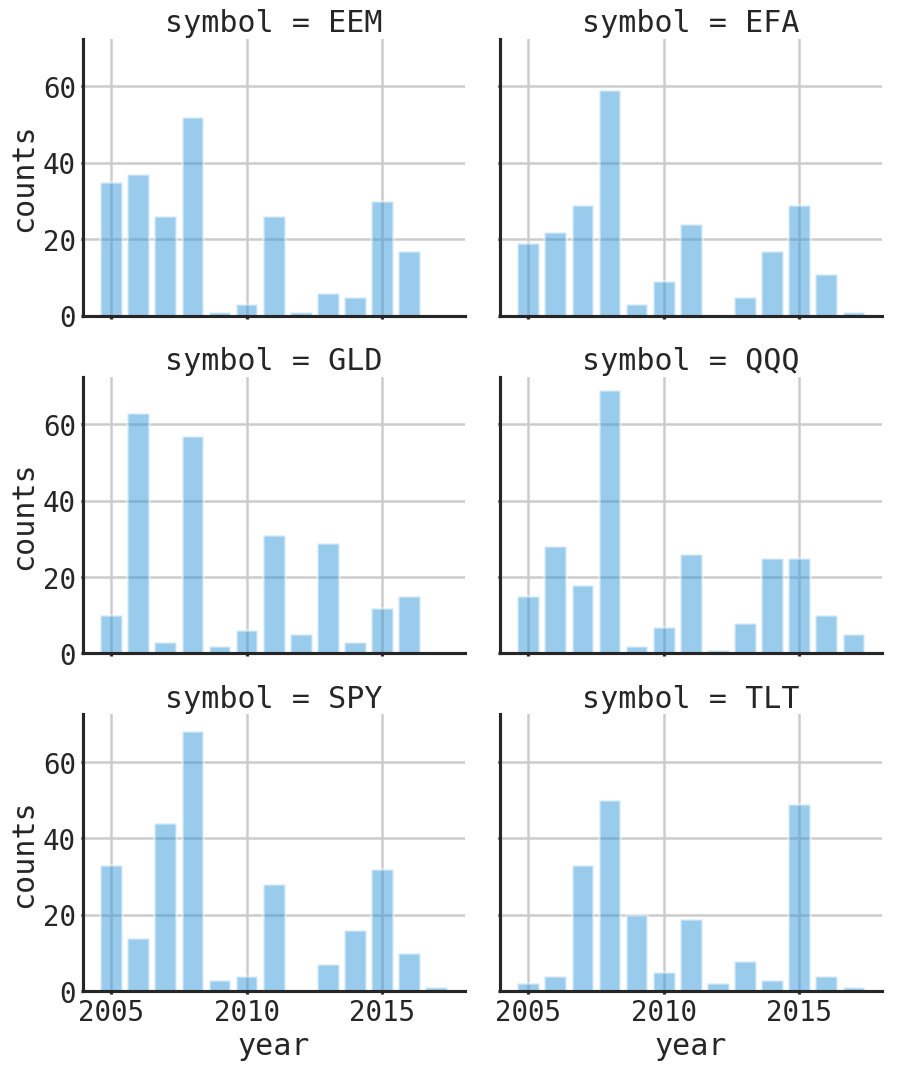

<IPython.core.display.Javascript object>

In [157]:
Image(visual_dir + "trade_counts_facet_grid.png", height=500, width=500)

## Conclusions

Regarding asset returns we've seen that the means and variances are not stationary, and that there is autocorrelation between returns at differing lags, and multiple time scales. We've also seen how there is potential for large errors/losses if we assume that the return distribution from the previous period(s) to the next are the same because in most cases they are not.

Hopefully this notebook shows that there is a need for a modeling framework that can assist in overcoming these challenges in a robust manner. In the next chapter I hope to demonstrate how mixture models approach these issues and the potential benefits they bring to this task.

## Resources and Citations

1. https://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/
2. https://pydata.github.io/pandas-datareader/stable/remote_data.html#tiingo
3. http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016